# **Prediction of Stocks Prices with Deep Learning**

In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript, clear_output
import os
import shutil
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.keras.backend.set_floatx('float64')

from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

%load_ext autoreload
%autoreload 2

from stocks.aux.stocks_data import MultiStocksDataset
from stocks.aux.eval import *
from stocks.aux.normalization import *
from stocks.aux.tf_callbacks import ClearCallback

Cloning into 'stocks'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (220/220), done.
remote: Total 220 (delta 136), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (220/220), 6.97 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% (136/136), done.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **0) Base settings**

In [62]:
NUM_SESSIONS = 10  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.75, 0.15, 0.1
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

INTERVAL = "1d"
NAME_LIST = set([
    # South America
    "^BVSP",                                        # Brazil
    # North America
    "^DJI", "^GSPC", "^IXIC", "^NYA", "^RUT",       # US
    "^MXX",                                         # Mexico
    "^GSPTSE",                                      # Canada
    # Europe
    "^FTSE", "^FCHI", "^GDAXI", "^IBEX", "^AEX", "^ATX",
    "^N100",  "^BFX", "^OMX",
    # Asia
    "000001.SS", "^HSI", "399001.SZ", "^TWII",      # China
    "^N225",                                        # Japan
    "^KS11",                                        # S. Korea 
    "^BSESN", "^NSEI",                              # India
    "TA35.TA",                                      # Israel
    # Oceania
    "^AORD",                                        # Australia
    
])

# loading stocks with specific params:
STOCKS = {
}

# loading stocks from NAME_LIST with default info (same params for all):
STOCKS.update({name: {"start": "2007-01-01",
                      "end": "2020-12-08",
                      "period": None} \
               for name in NAME_LIST})

## **1) Preparing the data**

#### **1.1) Fetching and pre-processing the data**

In [42]:
MAX_ZERO_VOL_PC = 0.5
multi_data = {}

for name, info in STOCKS.items():
    hist = Ticker(name).history(
        start=info["start"],
        end=info["end"],
        period=info["period"], 
        interval=INTERVAL
    ).reset_index("symbol", drop=True)
    hist = hist[["high", "close", "open", "low", "volume"]]
    
    zero_vols_pc = hist["volume"].isin([0]).sum() / len(hist)
    if zero_vols_pc > MAX_ZERO_VOL_PC:
        print(f"[WARNING] {100*zero_vols_pc : .2f}% of the" + \
              f"volumes of {name} are 0! Skipping symbol...")
    else:
        multi_data[name] = hist


multi_data = MultiStocksDataset(
    stocks=multi_data, 
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    batch_size=len(STOCKS) * 5,
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,
)

#### **1.2) Inspecting the data**



###################################   ^AEX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3564
. Zero volumes:  0.20%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,501.390015,501.000000,497.910004,497.859985,68535200
2007-01-03,501.799988,501.350006,501.480011,499.850006,96484400
2007-01-04,500.959991,500.329987,498.200012,497.929993,117535300
2007-01-05,499.209991,494.049988,498.390015,494.040009,125123300
2007-01-08,495.880005,492.809998,495.369995,491.420013,113168100
...,...,...,...,...,...
2020-12-01,613.409973,611.409973,609.000000,607.299988,108100
2020-12-02,612.320007,610.940002,608.760010,607.729980,99300
2020-12-03,613.260010,610.479980,612.429993,608.390015,89300



. Statistics:



,high,close,open,low,volume
count,3564.000000,3564.000000,3564.000000,3564.000000,3.564000e+03
mean,432.720315,430.012719,430.110413,427.147438,1.059102e+08
std,100.347470,100.366654,100.305411,100.367838,4.525575e+07
min,200.740005,199.250000,199.339996,194.990005,0.000000e+00
25%,342.335007,340.454994,340.225006,337.975006,7.882358e+07
50%,436.910004,432.870010,433.134995,428.495010,9.733515e+07
75%,525.290009,522.242477,522.852509,519.797485,1.223952e+08
max,632.119995,629.229980,630.559998,627.489990,5.278209e+08



. Plot:



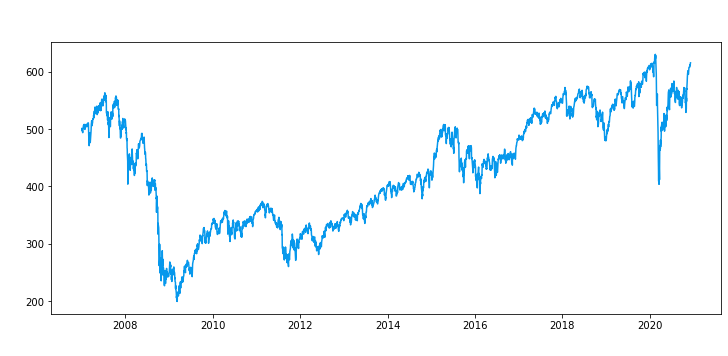



################################################################################




###################################   ^OMX   ###################################

. Period: from 2008-11-20 to 2020-12-07
. Trading sessions: 3021
. Zero volumes:  43.59%
. Data:



,high,close,open,low,volume
date,,,,,
2008-11-20,594.119995,587.710022,594.119995,572.469971,190921000.0
2008-11-21,594.799988,567.609985,587.710022,560.940002,188222800.0
2008-11-24,629.229980,626.460022,567.609985,567.609985,197755700.0
2008-11-25,644.549988,634.020020,626.460022,614.369995,258695400.0
2008-11-26,638.789978,628.859985,634.020020,617.489990,192007800.0
...,...,...,...,...,...
2020-12-01,1927.709961,1924.000000,1923.469971,1913.069946,0.0
2020-12-02,1925.859985,1918.989990,1916.359985,1914.109985,0.0
2020-12-03,1920.140015,1912.180054,1918.219971,1904.099976,0.0



. Statistics:



,high,close,open,low,volume
count,3021.000000,3021.000000,3021.000000,3021.000000,3.021000e+03
mean,1333.751708,1325.241148,1325.087227,1315.614583,6.073763e+07
std,297.437797,297.081314,297.306861,296.932366,6.192346e+07
min,594.119995,567.609985,567.609985,560.940002,0.000000e+00
25%,1085.030029,1079.640015,1078.790039,1071.189941,0.000000e+00
50%,1380.729980,1373.359985,1373.650024,1363.040039,6.666160e+07
75%,1585.439941,1576.550049,1576.729980,1569.430054,1.040502e+08
max,1950.810059,1938.140015,1941.380005,1929.699951,3.287206e+08



. Plot:



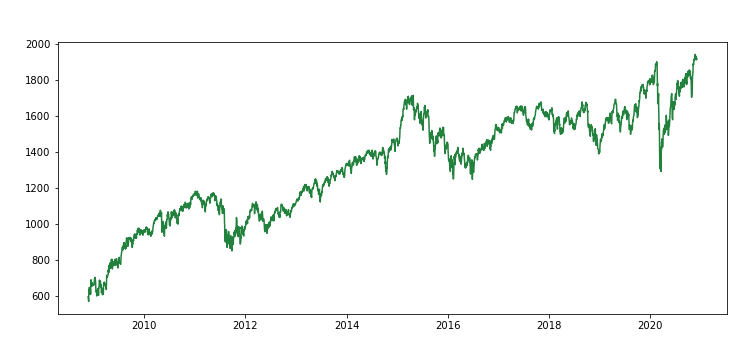



################################################################################




###################################   ^ATX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3453
. Zero volumes:  0.52%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,4559.529785,4558.959961,4463.290039,4460.839844,3487400.0
2007-01-03,4577.520020,4565.910156,4561.080078,4539.069824,5720400.0
2007-01-04,4562.939941,4515.169922,4562.430176,4466.229980,7697600.0
2007-01-05,4514.649902,4421.549805,4514.649902,4417.279785,6292000.0
2007-01-08,4422.970215,4381.500000,4419.439941,4348.259766,8095800.0
...,...,...,...,...,...
2020-12-01,2608.260010,2605.399902,2556.229980,2555.959961,4681000.0
2020-12-02,2610.110107,2607.600098,2600.300049,2591.939941,5316500.0
2020-12-03,2621.229980,2614.810059,2606.530029,2582.899902,6176400.0



. Statistics:



,high,close,open,low,volume
count,3453.000000,3453.000000,3453.000000,3453.000000,3.453000e+03
mean,2786.422971,2761.993888,2762.490115,2737.309075,6.165318e+06
std,736.394157,733.587201,734.122947,730.932170,3.167198e+06
min,1432.430054,1411.949951,1412.239990,1379.859985,0.000000e+00
25%,2271.739990,2251.169922,2251.179932,2229.360107,4.289800e+06
50%,2551.360107,2532.510010,2533.370117,2511.479980,5.603500e+06
75%,3156.189941,3133.510010,3133.620117,3113.320068,7.282600e+06
max,5010.930176,4981.870117,4982.430176,4970.919922,8.234560e+07



. Plot:



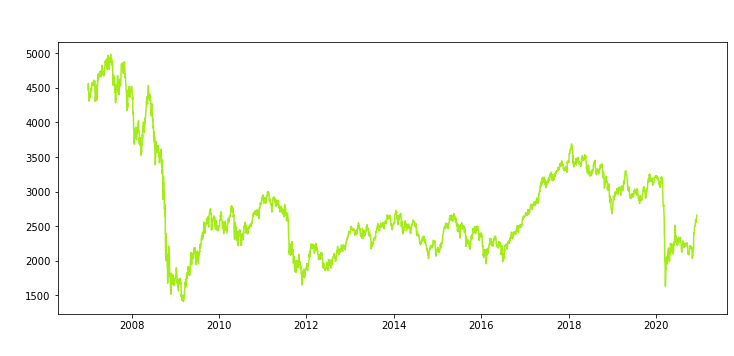



################################################################################




###################################   ^IBEX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3557
. Zero volumes:  0.08%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,14381.099609,14364.400391,14173.200195,14157.299805,184400.0
2007-01-03,14396.599609,14375.099609,14383.200195,14307.700195,199400.0
2007-01-04,14382.400391,14382.400391,14299.000000,14231.200195,214600.0
2007-01-05,14390.500000,14304.700195,14290.799805,14286.099609,227600.0
2007-01-08,14380.599609,14322.299805,14312.799805,14290.299805,214400.0
...,...,...,...,...,...
2020-12-01,8176.399902,8140.799805,8112.700195,8100.200195,284946100.0
2020-12-02,8226.200195,8220.799805,8111.100098,8104.200195,310837500.0
2020-12-03,8223.400391,8200.700195,8208.099609,8154.799805,233469300.0



. Statistics:



,high,close,open,low,volume
count,3557.000000,3557.000000,3557.000000,3557.000000,3.557000e+03
mean,10047.342767,9964.784518,9970.022974,9876.625558,1.725799e+08
std,1964.901602,1961.967033,1961.593976,1957.436525,1.301598e+08
min,6093.100098,5956.299805,5950.399902,5814.500000,0.000000e+00
25%,8763.200195,8686.099609,8685.900391,8603.299805,3.942000e+05
50%,9797.400391,9725.400391,9735.099609,9650.500000,1.807052e+08
75%,10835.000000,10746.500000,10748.200195,10663.000000,2.555740e+08
max,16040.400391,15945.700195,15999.200195,15868.599609,9.752120e+08



. Plot:



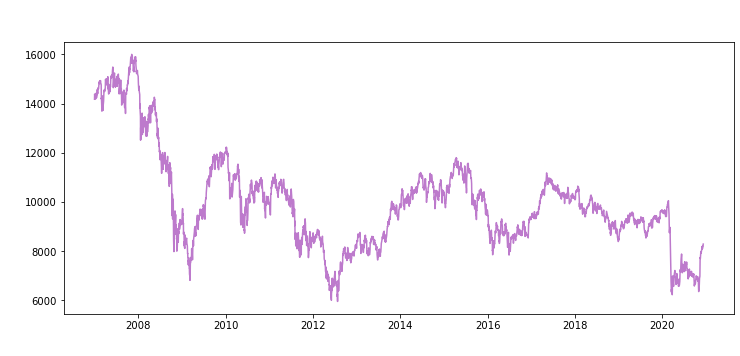



################################################################################




###################################   ^TWII   ###################################

. Period: from 2007-01-02 to 2020-12-08
. Trading sessions: 3418
. Zero volumes:  0.18%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,7937.259766,7920.799805,7871.410156,7843.600098,5710600.0
2007-01-03,7999.419922,7917.299805,7954.959961,7917.299805,5951400.0
2007-01-04,7955.899902,7934.509766,7929.890137,7901.240234,5717400.0
2007-01-05,7942.229980,7835.569824,7940.200195,7821.709961,5181400.0
2007-01-08,7797.569824,7736.709961,7778.569824,7736.109863,4292400.0
...,...,...,...,...,...
2020-12-02,13995.700195,13989.139648,13970.509766,13894.700195,6589100.0
2020-12-03,14049.580078,13977.089844,13988.490234,13940.070312,6081000.0
2020-12-04,14149.559570,14132.440430,14010.169922,14010.169922,6852600.0



. Statistics:



,high,close,open,low,volume
count,3418.000000,3418.000000,3418.000000,3418.000000,3.418000e+03
mean,8875.744063,8828.959005,8835.234209,8783.549513,2.902292e+06
std,1653.557424,1654.600284,1652.788941,1654.852198,1.348557e+06
min,4172.490234,4089.929932,3962.689941,3955.429932,0.000000e+00
25%,7839.504883,7798.169800,7805.087646,7753.512329,1.959125e+06
50%,8709.239746,8665.535156,8674.325195,8619.375000,2.428150e+06
75%,9850.987549,9817.372314,9808.597656,9762.060059,3.584525e+06
max,14367.000000,14360.400391,14251.940430,14184.580078,1.043880e+07



. Plot:



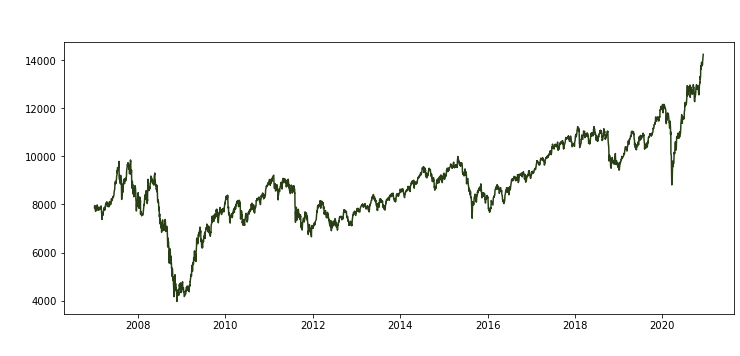



################################################################################




###################################   ^NSEI   ###################################

. Period: from 2007-09-17 to 2020-12-07
. Trading sessions: 3231
. Zero volumes:  40.76%
. Data:



,high,close,open,low,volume
date,,,,,
2007-09-17,4549.049805,4494.649902,4518.450195,4482.850098,0.0
2007-09-18,4551.799805,4546.200195,4494.100098,4481.549805,0.0
2007-09-19,4739.000000,4732.350098,4550.250000,4550.250000,0.0
2007-09-20,4760.850098,4747.549805,4734.850098,4721.149902,0.0
2007-09-21,4855.700195,4837.549805,4752.950195,4733.700195,0.0
...,...,...,...,...,...
2020-12-01,13128.400391,13109.049805,13062.200195,12962.799805,583600.0
2020-12-02,13128.500000,13113.750000,13121.400391,12983.549805,717700.0
2020-12-03,13216.599609,13133.900391,13215.299805,13107.900391,713700.0



. Statistics:



,high,close,open,low,volume
count,3231.000000,3231.000000,3231.000000,3231.000000,3.231000e+03
mean,7461.919873,7410.947527,7416.382267,7358.858848,1.696420e+05
std,2557.915747,2554.474736,2558.455732,2551.888330,2.136351e+05
min,2585.300049,2524.199951,2553.600098,2252.750000,0.000000e+00
25%,5340.325195,5298.425049,5299.100098,5256.399902,0.000000e+00
50%,6825.450195,6796.399902,6792.700195,6772.850098,1.407000e+05
75%,9645.350098,9615.549805,9616.725098,9572.975098,2.215000e+05
max,13366.650391,13355.750000,13264.849609,13241.950195,1.811000e+06



. Plot:



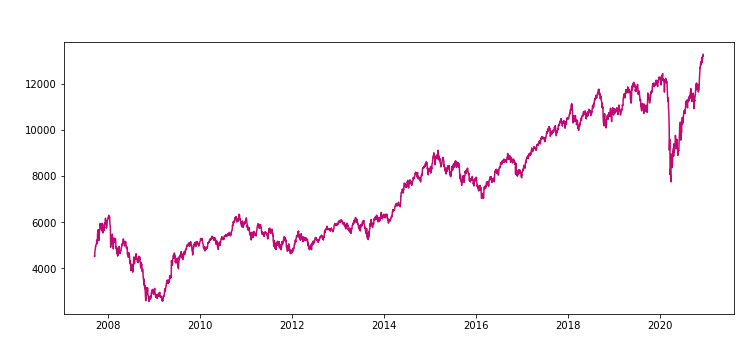



################################################################################




###################################   ^RUT   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3507
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-03,796.619995,787.419983,788.309998,779.309998,34291600.0
2007-01-04,791.830017,789.950012,786.419983,779.700012,30044600.0
2007-01-05,787.700012,775.869995,787.700012,774.549988,29194000.0
2007-01-08,778.830017,776.989990,776.200012,769.270020,27633400.0
2007-01-09,778.739990,778.330017,777.099976,768.690002,30383800.0
...,...,...,...,...,...
2020-12-01,1848.020020,1836.050049,1822.920044,1822.920044,54036600.0
2020-12-02,1842.530029,1838.030029,1833.079956,1817.020020,50296200.0
2020-12-03,1860.349976,1848.699951,1838.520020,1838.520020,50917600.0



. Statistics:



,high,close,open,low,volume
count,3507.000000,3507.000000,3507.000000,3507.000000,3.507000e+03
mean,1063.808138,1056.419362,1056.263838,1048.010268,4.082089e+07
std,358.444419,357.389360,357.275298,356.238416,5.338202e+07
min,355.049988,343.260010,347.380005,342.589996,5.362000e+06
25%,768.649994,763.654999,763.195007,754.220001,3.283220e+07
50%,1082.680054,1074.510010,1073.689941,1065.619995,3.723790e+07
75%,1381.969971,1372.295044,1372.139954,1364.164978,4.429165e+07
max,1897.439941,1892.449951,1892.719971,1886.780029,3.125950e+09



. Plot:



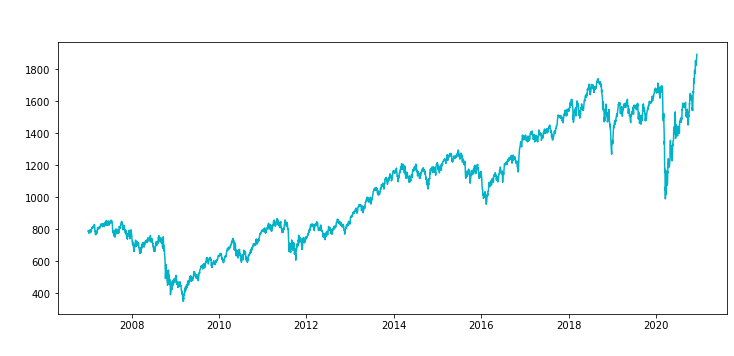



################################################################################




###################################   ^DJI   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-03,12580.349609,12474.519531,12459.540039,12404.820312,327200000
2007-01-04,12510.410156,12480.690430,12473.160156,12403.860352,259060000
2007-01-05,12480.129883,12398.009766,12480.049805,12365.410156,235220000
2007-01-08,12445.919922,12423.490234,12392.009766,12337.370117,223500000
2007-01-09,12466.429688,12416.599609,12424.769531,12369.169922,225190000
...,...,...,...,...,...
2020-12-01,30083.310547,29823.919922,29797.500000,29797.500000,429510000
2020-12-02,29902.509766,29883.789062,29695.089844,29599.289062,385280000
2020-12-03,30110.880859,29969.519531,29920.830078,29877.269531,405680000



. Statistics:



,high,close,open,low,volume
count,3508.000000,3508.000000,3508.000000,3508.000000,3.508000e+03
mean,16906.871683,16813.076871,16810.276410,16708.053692,2.226696e+08
std,5879.175834,5859.127776,5859.705774,5838.608275,1.305168e+08
min,6709.609863,6547.049805,6547.009766,6469.950195,8.410000e+06
25%,12380.577881,12284.937744,12284.360107,12210.927490,1.185300e+08
50%,16010.379883,15887.494629,15889.830078,15806.234863,2.029200e+08
75%,21235.201660,21151.557129,21132.205078,21019.822266,2.936650e+08
max,30233.029297,30218.259766,30233.029297,29989.560547,2.190810e+09



. Plot:



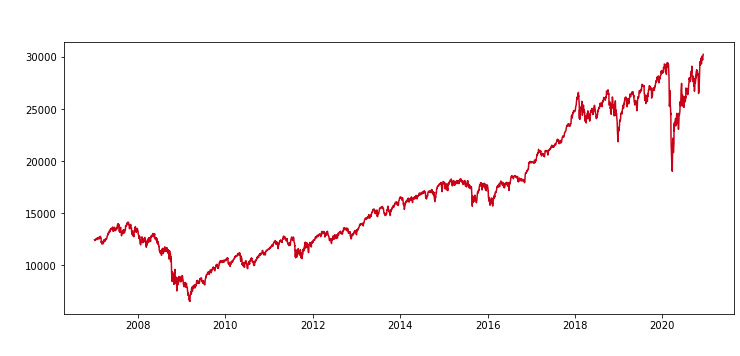



################################################################################




###################################   ^BSESN   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3413
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,13980.540039,13942.240234,13827.769531,13797.440430,9600.0
2007-01-03,14035.669922,14014.919922,13969.450195,13897.419922,11600.0
2007-01-04,14060.349609,13871.709961,14029.040039,13850.379883,14600.0
2007-01-05,13971.820312,13860.519531,13768.790039,13763.389648,13200.0
2007-01-08,13855.889648,13652.150391,13855.889648,13599.870117,11600.0
...,...,...,...,...,...
2020-12-01,44730.789062,44655.441406,44435.828125,44118.101562,16000.0
2020-12-02,44729.640625,44618.039062,44729.519531,44169.968750,16000.0
2020-12-03,44953.011719,44632.648438,44902.019531,44551.421875,30700.0



. Statistics:



,high,close,open,low,volume
count,3413.000000,3413.000000,3413.000000,3413.000000,3.413000e+03
mean,24213.195151,24044.995860,24073.112904,23884.709588,1.099451e+05
std,8625.882623,8599.338820,8615.774067,8578.818649,1.280042e+06
min,8259.219727,8160.399902,8103.750000,7697.390137,8.000000e+02
25%,17359.179688,17230.179688,17246.880859,17105.220703,1.040000e+04
50%,20922.320312,20812.650391,20845.769531,20656.699219,1.410000e+04
75%,30965.449219,30582.599609,30638.880859,30352.259766,2.000000e+04
max,45458.921875,45426.968750,45099.921875,45024.468750,3.181510e+07



. Plot:



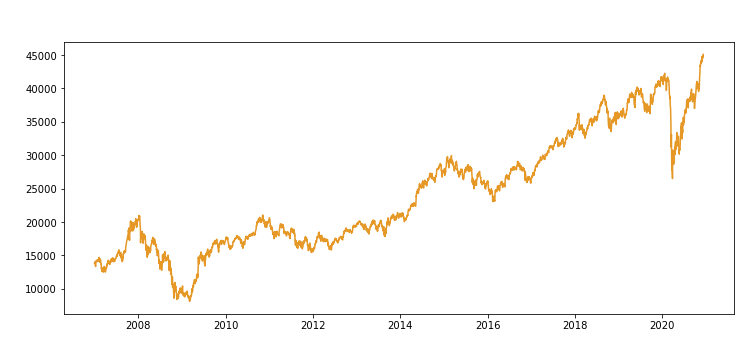



################################################################################




###################################   ^IXIC   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-03,2454.620117,2423.159912,2429.719971,2394.659912,2435280000
2007-01-04,2460.510010,2453.429932,2423.820068,2413.750000,2104210000
2007-01-05,2445.070068,2434.250000,2445.070068,2420.590088,2060360000
2007-01-08,2445.629883,2438.199951,2435.250000,2421.129883,1905620000
2007-01-09,2449.870117,2443.830078,2443.260010,2423.560059,2144160000
...,...,...,...,...,...
2020-12-01,12405.790039,12355.110352,12313.360352,12263.929688,6467180000
2020-12-02,12360.059570,12349.370117,12285.750000,12217.349609,5150820000
2020-12-03,12439.019531,12377.179688,12369.259766,12356.990234,5182100000



. Statistics:



,high,close,open,low,volume
count,3508.000000,3508.000000,3508.000000,3508.000000,3.508000e+03
mean,4577.073657,4549.848133,4548.891445,4517.866491,2.137794e+09
std,2449.162432,2434.667259,2433.940049,2417.155135,6.660341e+08
min,1316.150024,1268.640015,1284.839966,1265.520020,1.494100e+08
25%,2570.992554,2554.312500,2555.802429,2535.134949,1.777898e+09
50%,4066.150024,4045.005005,4041.214966,4021.585083,1.988540e+09
75%,6218.502441,6193.697388,6203.107544,6150.790039,2.270200e+09
max,12536.230469,12519.950195,12461.000000,12460.549805,7.693430e+09



. Plot:



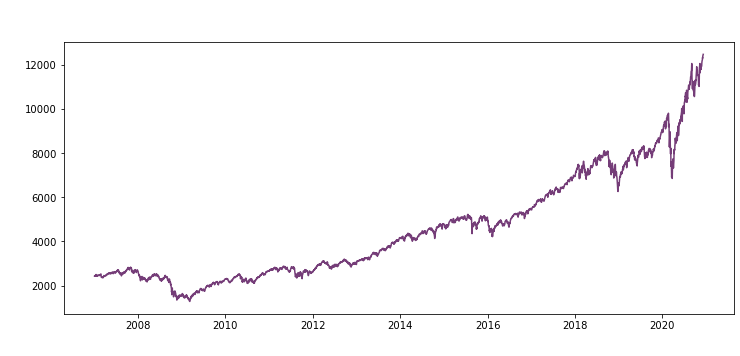



################################################################################




###################################   ^KS11   ###################################

. Period: from 2007-01-02 to 2020-12-08
. Trading sessions: 3431
. Zero volumes:  0.23%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,1439.709961,1435.260010,1438.890015,1430.060059,147800.0
2007-01-03,1437.790039,1409.349976,1436.420044,1409.310059,203200.0
2007-01-04,1411.119995,1397.290039,1410.550049,1388.500000,241200.0
2007-01-05,1400.589966,1385.760010,1398.599976,1372.359985,277200.0
2007-01-08,1384.650024,1370.810059,1376.760010,1366.479980,177600.0
...,...,...,...,...,...
2020-12-02,2677.260010,2675.899902,2645.879883,2644.530029,1076200.0
2020-12-03,2696.219971,2696.219971,2686.379883,2672.850098,817100.0
2020-12-04,2742.770020,2731.449951,2705.340088,2705.340088,1778900.0



. Statistics:



,high,close,open,low,volume
count,3431.000000,3431.000000,3431.000000,3431.000000,3.431000e+03
mean,1951.358234,1940.508111,1941.529349,1933.431775,5.711032e+05
std,293.833566,294.930761,295.126276,416.092098,6.130089e+06
min,966.409973,938.750000,916.849976,892.159973,0.000000e+00
25%,1831.229980,1818.984985,1818.190002,1802.179993,3.066500e+05
50%,1985.569946,1976.750000,1977.609985,1968.500000,3.783000e+05
75%,2093.459961,2083.740112,2085.060059,2072.515015,4.812000e+05
max,2754.010010,2745.439941,2745.129883,19025.550781,2.607250e+08



. Plot:



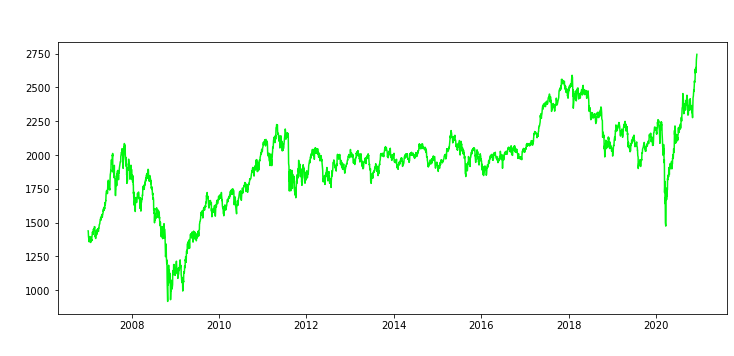



################################################################################




###################################   ^GSPC   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-03,1429.420044,1416.599976,1418.030029,1407.859985,3429160000
2007-01-04,1421.839966,1418.339966,1416.599976,1408.430054,3004460000
2007-01-05,1418.339966,1409.709961,1418.339966,1405.750000,2919400000
2007-01-08,1414.979980,1412.839966,1409.260010,1403.969971,2763340000
2007-01-09,1415.609985,1412.109985,1412.839966,1405.420044,3038380000
...,...,...,...,...,...
2020-12-01,3678.449951,3662.449951,3645.870117,3645.870117,5403660000
2020-12-02,3670.959961,3669.010010,3653.780029,3644.840088,5029620000
2020-12-03,3682.729980,3666.719971,3668.280029,3657.169922,5091760000



. Statistics:



,high,close,open,low,volume
count,3508.000000,3508.000000,3508.000000,3508.000000,3.508000e+03
mean,1893.805136,1883.547733,1883.267775,1871.747019,3.993587e+09
std,697.095831,695.090407,695.057231,692.771787,1.155038e+09
min,695.270020,676.530029,679.280029,666.789978,1.025000e+09
25%,1330.257538,1320.597504,1319.882538,1312.359985,3.282788e+09
50%,1802.649963,1797.600037,1796.704956,1788.179993,3.724025e+09
75%,2432.819946,2420.627441,2424.757507,2407.777466,4.426885e+09
max,3699.199951,3699.120117,3694.729980,3678.879883,1.145623e+10



. Plot:



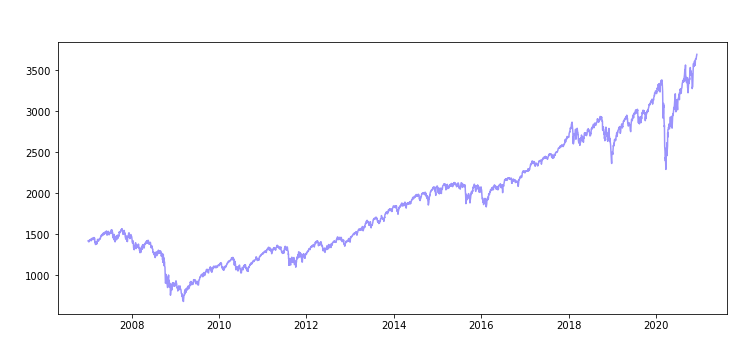



################################################################################




###################################   ^BFX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3560
. Zero volumes:  19.55%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,4458.169922,4454.160156,4401.060059,4399.089844,5627000.0
2007-01-03,4471.899902,4466.930176,4451.589844,4445.839844,7202200.0
2007-01-04,4448.240234,4421.259766,4440.870117,4419.620117,10463000.0
2007-01-05,4427.910156,4381.560059,4410.379883,4381.549805,7647400.0
2007-01-08,4428.529785,4406.589844,4396.830078,4390.939941,9030200.0
...,...,...,...,...,...
2020-12-01,3717.929932,3717.679932,3677.709961,3672.669922,25600.0
2020-12-02,3712.340088,3709.689941,3693.750000,3684.530029,30900.0
2020-12-03,3724.310059,3714.790039,3707.149902,3686.000000,25400.0



. Statistics:



,high,close,open,low,volume
count,3560.000000,3560.000000,3560.000000,3560.000000,3.560000e+03
mean,3196.446925,3176.039435,3177.401755,3154.993933,1.918665e+07
std,708.790327,708.391234,707.824237,707.573827,1.855616e+07
min,1571.810059,1527.270020,1564.310059,1523.469971,0.000000e+00
25%,2585.164978,2565.644958,2568.762451,2547.712585,8.905025e+06
50%,3325.689941,3295.059937,3289.585083,3265.325073,1.707180e+07
75%,3745.052551,3724.619995,3723.130005,3701.265015,2.608008e+07
max,4759.009766,4756.819824,4737.319824,4733.049805,2.252646e+08



. Plot:



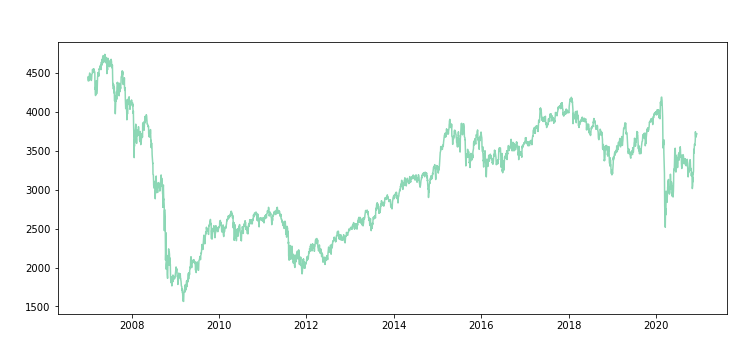



################################################################################




###################################   ^FTSE   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3511
. Zero volumes:  0.00%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,6312.500000,6310.899902,6220.799805,6220.799805,1.074946e+09
2007-01-03,6322.000000,6319.000000,6310.899902,6296.000000,1.606893e+09
2007-01-04,6319.000000,6287.000000,6319.000000,6261.000000,1.902876e+09
2007-01-05,6287.000000,6220.100098,6287.000000,6220.100098,1.622439e+09
2007-01-08,6246.000000,6194.200195,6220.100098,6187.000000,1.326701e+09
...,...,...,...,...,...
2020-12-01,6400.200195,6384.700195,6266.200195,6263.600098,8.398583e+08
2020-12-02,6468.600098,6463.399902,6384.700195,6367.500000,9.368428e+08
2020-12-03,6491.500000,6490.299805,6463.399902,6430.299805,9.432145e+08



. Statistics:



,high,close,open,low,volume
count,3511.000000,3511.000000,3511.000000,3511.000000,3.511000e+03
mean,6309.162606,6267.233408,6267.175618,6223.639992,9.436311e+08
std,865.302028,873.454391,873.435789,882.630251,3.936803e+08
min,3564.800049,3512.100098,3512.100098,3460.699951,6.676710e+07
25%,5790.149902,5752.100098,5752.100098,5707.400146,6.825844e+08
50%,6367.799805,6331.799805,6330.500000,6280.100098,8.236307e+08
75%,6917.650146,6887.850098,6887.850098,6848.350098,1.087422e+09
max,7903.500000,7877.500000,7877.500000,7854.600098,3.761301e+09



. Plot:



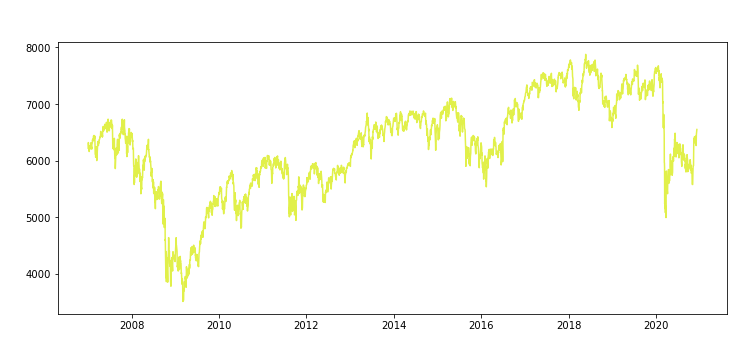



################################################################################




###################################   ^BVSP   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3441
. Zero volumes:  1.22%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,45388.0,45383.0,44476.0,44476.0,75560200.0
2007-01-03,45379.0,44445.0,45379.0,44284.0,122372800.0
2007-01-04,44442.0,44020.0,44442.0,43623.0,86577000.0
2007-01-05,44081.0,42245.0,44019.0,42160.0,164055000.0
2007-01-08,42926.0,42830.0,42249.0,42144.0,114007100.0
...,...,...,...,...,...
2020-12-01,111840.0,111335.0,108897.0,108897.0,11324800.0
2020-12-02,112315.0,111814.0,111402.0,110579.0,9814300.0
2020-12-03,113377.0,112919.0,111874.0,111874.0,11474200.0



. Statistics:



,high,close,open,low,volume
count,3441.000000,3441.000000,3441.00000,3441.000000,3.441000e+03
mean,65241.841616,64588.594885,64568.33159,63899.225516,8.226186e+06
std,17668.235175,17590.489320,17568.05804,17483.078299,2.272670e+07
min,31480.000000,29435.000000,29438.00000,29435.000000,0.000000e+00
25%,53312.000000,52764.000000,52758.00000,52190.000000,2.243600e+06
50%,61188.000000,60452.000000,60416.00000,59815.000000,3.313000e+06
75%,70958.000000,70385.000000,70377.00000,69698.000000,4.578200e+06
max,119593.000000,119528.000000,119528.00000,118108.000000,2.322653e+08



. Plot:



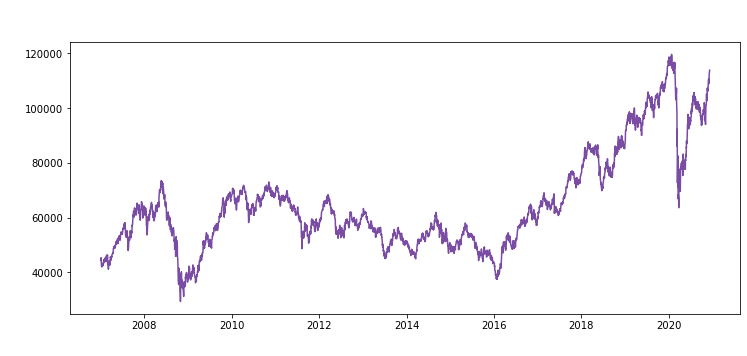



################################################################################




###################################   ^NYA   ###################################

. Period: from 2007-01-03 to 2020-12-07
. Trading sessions: 3508
. Zero volumes:  0.40%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-03,9209.299805,9133.080078,9137.959961,9092.950195,3429160000
2007-01-04,9132.250000,9113.160156,9132.250000,9070.110352,0
2007-01-05,9113.160156,9025.040039,9113.160156,9002.330078,2919400000
2007-01-08,9052.099609,9041.120117,9025.040039,8993.620117,2763340000
2007-01-09,9048.269531,9023.900391,9041.099609,8984.200195,3038380000
...,...,...,...,...,...
2020-12-01,14233.459961,14146.639648,14183.450195,14131.330078,5403660000
2020-12-02,14198.790039,14188.240234,14104.059570,14076.709961,5029620000
2020-12-03,14283.730469,14217.179688,14210.540039,14184.490234,5091760000



. Statistics:



,high,close,open,low,volume
count,3508.000000,3508.000000,3508.000000,3508.000000,3.508000e+03
mean,9890.779830,9837.302246,9837.355669,9776.581320,3.979311e+09
std,2183.914597,2190.938159,2190.941292,2199.522523,1.183190e+09
min,4321.759766,4226.310059,4226.310059,4181.750000,0.000000e+00
25%,8164.117432,8123.047363,8123.010010,8077.035156,3.275395e+09
50%,10051.899902,10005.830078,10005.115234,9943.334961,3.720505e+09
75%,11521.532959,11465.472412,11481.852783,11419.790283,4.424832e+09
max,14417.400391,14417.330078,14375.549805,14314.469727,1.145623e+10



. Plot:



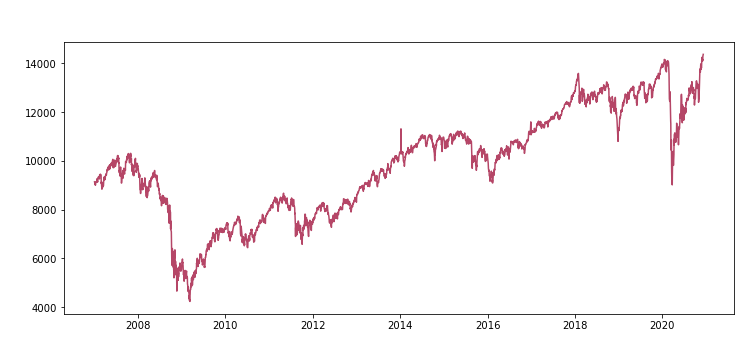



################################################################################




###################################   ^GDAXI   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3530
. Zero volumes:  2.12%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,6682.810059,6681.129883,6614.729980,6614.729980,70947800.0
2007-01-03,6704.040039,6691.319824,6681.229980,6667.580078,105913800.0
2007-01-04,6684.109863,6674.399902,6662.240234,6634.740234,143461600.0
2007-01-05,6665.509766,6593.089844,6661.899902,6588.029785,142562500.0
2007-01-08,6628.359863,6607.589844,6603.549805,6579.899902,116670200.0
...,...,...,...,...,...
2020-12-01,13434.299805,13382.299805,13371.660156,13334.990234,66675500.0
2020-12-02,13359.269531,13313.240234,13341.910156,13272.469727,63822100.0
2020-12-03,13307.540039,13252.860352,13304.830078,13223.929688,64310300.0



. Statistics:



,high,close,open,low,volume
count,3530.000000,3530.000000,3530.000000,3530.000000,3.530000e+03
mean,9068.592041,9005.275302,9006.391127,8937.903796,1.152738e+08
std,2665.546241,2659.779823,2660.150769,2654.731870,5.485129e+07
min,3706.320068,3666.409912,3677.070068,3588.889893,0.000000e+00
25%,6774.742554,6724.060059,6724.612671,6664.679810,8.103605e+07
50%,9076.224609,9017.540039,9032.479980,8971.824707,1.039062e+08
75%,11616.982666,11549.830078,11560.134766,11484.594727,1.374964e+08
max,13795.240234,13789.000000,13774.440430,13754.040039,4.940122e+08



. Plot:



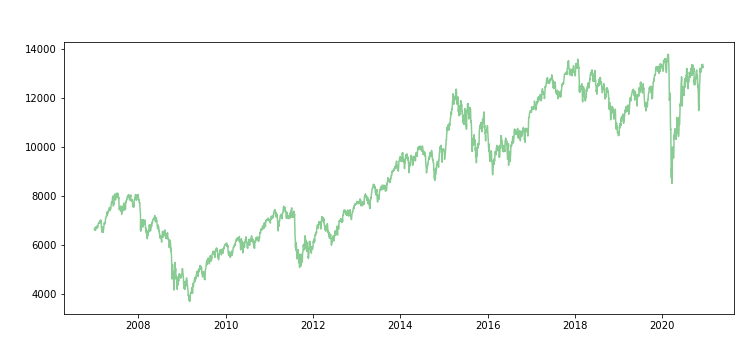



################################################################################




###################################   TA35.TA   ###################################

. Period: from 2007-01-01 to 2020-12-07
. Trading sessions: 3391
. Zero volumes:  42.67%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-01,942.570007,941.130005,926.299988,926.299988,0.0
2007-01-02,948.419983,940.369995,941.130005,938.200012,0.0
2007-01-03,946.450012,945.859985,940.369995,937.650024,0.0
2007-01-04,946.539978,941.070007,945.859985,938.909973,0.0
2007-01-07,939.679993,932.719971,939.070007,930.809998,0.0
...,...,...,...,...,...
2020-12-01,1470.839966,1458.380005,1469.400024,1456.579956,33883000.0
2020-12-02,1452.469971,1436.349976,1452.469971,1433.520020,32555600.0
2020-12-03,1448.060059,1447.020020,1438.099976,1438.099976,48730200.0



. Statistics:



,high,close,open,low,volume
count,3391.000000,3391.000000,3391.000000,3391.000000,3.391000e+03
mean,1299.761799,1293.453126,1293.867676,1287.069439,2.837058e+07
std,238.509084,238.944003,238.949797,239.478539,3.383516e+07
min,623.659973,592.070007,599.409973,590.960022,0.000000e+00
25%,1124.655029,1119.510010,1120.174988,1112.700012,0.000000e+00
50%,1328.560059,1321.939941,1320.920044,1314.869995,2.376000e+07
75%,1466.325012,1461.344971,1462.155029,1457.020020,4.552400e+07
max,1751.790039,1751.790039,1743.170044,1731.890015,2.995762e+08



. Plot:



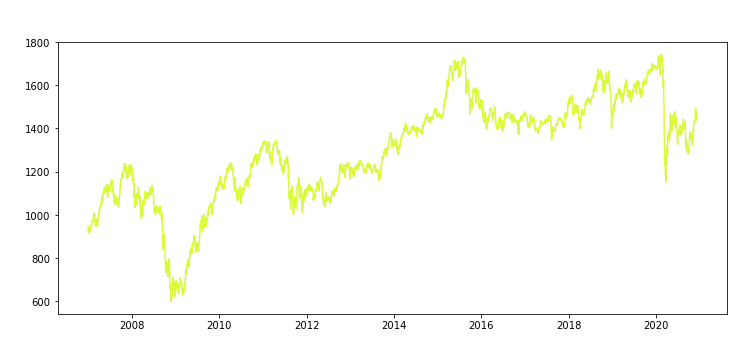



################################################################################




###################################   ^FCHI   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3561
. Zero volumes:  0.87%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,5621.649902,5617.709961,5575.759766,5575.629883,85910000.0
2007-01-03,5623.669922,5610.919922,5621.000000,5596.819824,118580700.0
2007-01-04,5585.540039,5574.560059,5573.729980,5547.169922,130465700.0
2007-01-05,5566.240234,5517.350098,5552.640137,5517.350098,126420500.0
2007-01-08,5555.669922,5518.589844,5532.569824,5509.060059,115053800.0
...,...,...,...,...,...
2020-12-01,5589.680176,5581.640137,5542.459961,5529.250000,0.0
2020-12-02,5585.870117,5583.009766,5563.049805,5549.790039,0.0
2020-12-03,5584.100098,5574.359863,5581.529785,5546.290039,0.0



. Statistics:



,high,close,open,low,volume
count,3561.000000,3561.000000,3561.000000,3561.000000,3.561000e+03
mean,4500.303566,4468.682668,4469.857024,4435.208128,1.225558e+08
std,836.654594,839.218522,838.511388,841.721132,5.239255e+07
min,2552.989990,2519.290039,2519.429932,2465.459961,0.000000e+00
25%,3832.020020,3799.110107,3796.790039,3764.840088,8.611700e+07
50%,4469.839844,4439.669922,4437.990234,4407.180176,1.150538e+08
75%,5208.850098,5176.609863,5179.839844,5143.819824,1.479996e+08
max,6168.149902,6168.149902,6157.330078,6112.290039,5.312476e+08



. Plot:



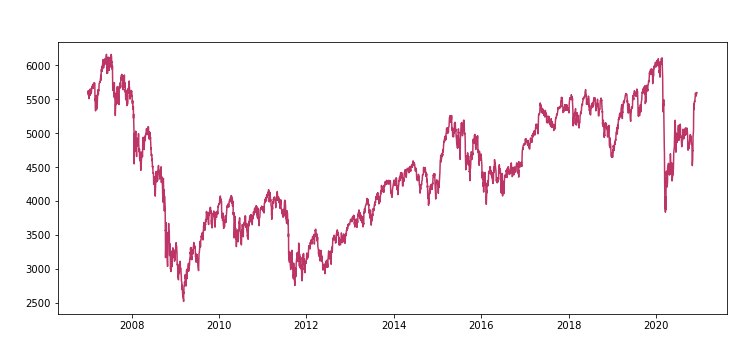



################################################################################




###################################   ^GSPTSE   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3499
. Zero volumes:  0.09%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,12989.599609,12923.700195,12924.500000,12908.400391,60857400
2007-01-03,12926.400391,12701.400391,12919.200195,12672.799805,199791400
2007-01-04,12701.400391,12553.599609,12679.200195,12519.400391,247371600
2007-01-05,12553.599609,12478.000000,12517.599609,12439.299805,201713900
2007-01-08,12617.299805,12553.099609,12558.299805,12478.000000,172708200
...,...,...,...,...,...
2020-12-01,17471.199219,17296.900391,17431.300781,17285.300781,296753900
2020-12-02,17358.300781,17358.199219,17278.099609,17220.900391,261964200
2020-12-03,17452.900391,17398.000000,17386.000000,17382.000000,251025700



. Statistics:



,high,close,open,low,volume
count,3499.000000,3499.000000,3499.000000,3499.000000,3.499000e+03
mean,13825.890445,13753.688545,13757.149638,13674.732351,2.070628e+08
std,1918.981164,1937.410226,1936.528171,1958.717604,7.833546e+07
min,7695.299805,7566.899902,7527.399902,7480.000000,0.000000e+00
25%,12509.149902,12440.149902,12425.399902,12354.500000,1.685738e+08
50%,13877.400391,13797.000000,13807.500000,13718.599609,2.007466e+08
75%,15314.449707,15251.100098,15251.550293,15180.699707,2.359549e+08
max,17970.500000,17944.099609,17936.500000,17860.599609,9.440374e+08



. Plot:



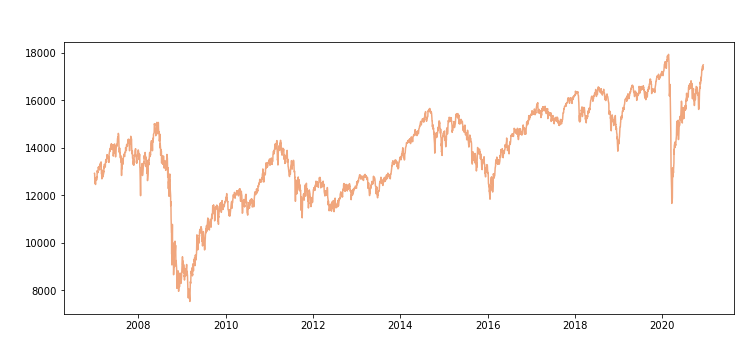



################################################################################




###################################   ^N225   ###################################

. Period: from 2007-01-04 to 2020-12-08
. Trading sessions: 3404
. Zero volumes:  0.35%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-04,17379.460938,17353.669922,17322.500000,17315.759766,80100.0
2007-01-05,17327.130859,17091.589844,17315.539062,17011.099609,158600.0
2007-01-09,17261.029297,17237.769531,17018.890625,16983.970703,142400.0
2007-01-10,17199.419922,16942.400391,17192.419922,16847.570312,133500.0
2007-01-11,17057.449219,16838.169922,16958.570312,16758.460938,121900.0
...,...,...,...,...,...
2020-12-02,26889.900391,26800.980469,26884.990234,26695.279297,80200.0
2020-12-03,26868.089844,26809.369141,26740.300781,26719.230469,69500.0
2020-12-04,26799.830078,26751.240234,26697.259766,26646.080078,61600.0



. Statistics:



,high,close,open,low,volume
count,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000
mean,15688.987110,15596.231734,15598.865763,15500.247325,130463.895417
std,5023.118341,5011.910772,5009.701462,4994.682542,52782.598861
min,7100.770020,7054.979980,7059.770020,6994.899902,0.000000
25%,10292.082275,10234.902344,10255.720459,10183.159912,97175.000000
50%,15960.805176,15847.680176,15850.299805,15738.535156,127100.000000
75%,20025.545410,19956.359375,19968.093262,19897.271973,154825.000000
max,26894.250000,26809.369141,26894.250000,26719.230469,595200.000000



. Plot:



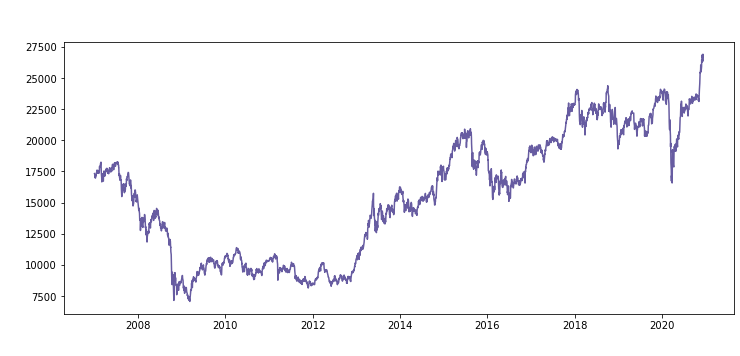



################################################################################




###################################   ^HSI   ###################################

. Period: from 2007-01-02 to 2020-12-08
. Trading sessions: 3428
. Zero volumes:  0.29%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,20323.589844,20310.179688,20004.839844,19990.279297,1.264597e+09
2007-01-03,20554.580078,20413.390625,20353.419922,20249.609375,1.673969e+09
2007-01-04,20463.179688,20025.580078,20415.669922,19948.019531,2.130510e+09
2007-01-05,20213.640625,20211.279297,19890.150391,19757.240234,1.959114e+09
2007-01-08,20085.580078,20029.660156,19915.000000,19844.310547,1.438589e+09
...,...,...,...,...,...
2020-12-02,26670.119141,26532.580078,26670.119141,26379.480469,3.704087e+09
2020-12-03,26781.990234,26728.500000,26623.419922,26556.019531,2.830414e+09
2020-12-04,26835.919922,26835.919922,26811.589844,26652.339844,3.205350e+09



. Statistics:



,high,close,open,low,volume
count,3428.000000,3428.000000,3428.000000,3428.000000,3.428000e+03
mean,23351.753502,23199.532928,23213.666440,23041.982951,1.863207e+09
std,3650.342078,3646.793782,3651.162608,3645.047505,7.516074e+08
min,11747.110352,11015.839844,11154.570312,10676.290039,0.000000e+00
25%,21056.794922,20937.274414,20961.158203,20818.089355,1.394423e+09
50%,23144.895508,23014.239258,23026.780273,22872.375000,1.704621e+09
75%,25655.597168,25479.555664,25501.267578,25274.897461,2.133712e+09
max,33484.078125,33154.121094,33335.480469,32897.039062,9.799120e+09



. Plot:



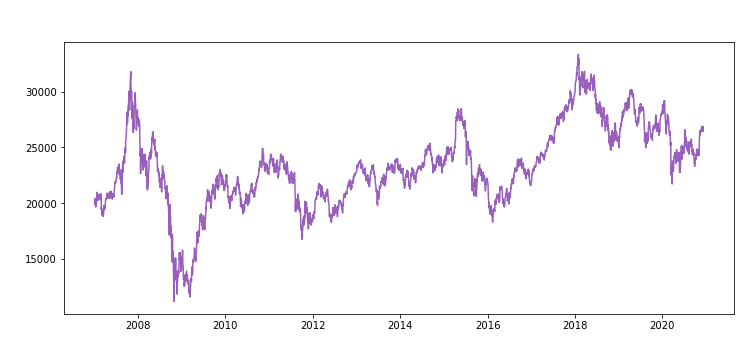



################################################################################




###################################   ^MXX   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3489
. Zero volumes:  0.17%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,26666.919922,26664.449219,26448.320312,26448.320312,37688400.0
2007-01-03,26699.099609,26619.369141,26666.839844,26319.500000,134658000.0
2007-01-04,26623.060547,26566.279297,26622.109375,26335.419922,103649000.0
2007-01-05,26566.279297,26135.599609,26566.279297,26112.769531,105575400.0
2007-01-08,26282.390625,26281.640625,26135.599609,26071.660156,122179800.0
...,...,...,...,...,...
2020-12-01,43204.101562,42895.628906,41987.429688,41902.769531,224469600.0
2020-12-02,43730.960938,43674.828125,43010.480469,42956.730469,174294200.0
2020-12-03,44013.109375,43934.210938,43512.269531,43477.660156,175436600.0



. Statistics:



,high,close,open,low,volume
count,3489.000000,3489.000000,3489.000000,3489.000000,3.489000e+03
mean,39027.948048,38774.117235,38772.636587,38505.092997,1.845977e+08
std,7665.667083,7677.208003,7679.970295,7690.366310,9.061487e+07
min,17203.449219,16891.029297,16867.390625,16480.009766,0.000000e+00
25%,32809.558594,32679.359375,32666.160156,32429.669922,1.367115e+08
50%,40958.648438,40711.558594,40706.441406,40401.078125,1.701641e+08
75%,44844.738281,44597.320312,44593.890625,44338.519531,2.153290e+08
max,51772.371094,51713.378906,51590.480469,51524.230469,1.759968e+09



. Plot:



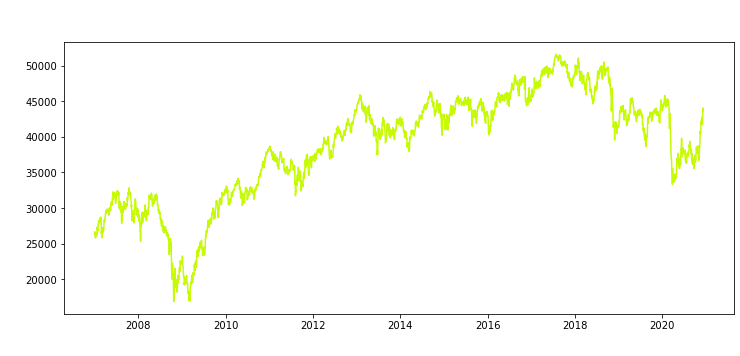



################################################################################




###################################   ^AORD   ###################################

. Period: from 2007-01-02 to 2020-12-08
. Trading sessions: 3524
. Zero volumes:  0.79%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,5664.299805,5645.899902,5646.899902,5645.000000,3.090681e+08
2007-01-03,5671.100098,5626.799805,5656.000000,5621.399902,4.102638e+08
2007-01-04,5614.500000,5563.899902,5613.899902,5563.899902,6.367908e+08
2007-01-05,5587.799805,5549.799805,5559.500000,5543.700195,5.656764e+08
2007-01-08,5541.200195,5484.500000,5539.700195,5482.100098,6.439050e+08
...,...,...,...,...,...
2020-12-02,6840.799805,6811.299805,6812.200195,6784.399902,1.024029e+09
2020-12-03,6861.700195,6847.299805,6811.299805,6811.299805,9.869194e+08
2020-12-04,6879.399902,6865.299805,6847.299805,6846.399902,8.728332e+08



. Statistics:



,high,close,open,low,volume
count,3524.000000,3524.000000,3524.000000,3524.000000,3.524000e+03
mean,5377.772190,5349.188448,5348.937062,5319.625848,9.631880e+08
std,821.682211,822.372658,821.796191,822.052119,3.436450e+08
min,3133.100098,3111.699951,3116.000000,3090.800049,0.000000e+00
25%,4769.949951,4746.425049,4746.375000,4723.850098,7.607804e+08
50%,5419.750000,5394.649902,5394.050049,5364.000000,8.873383e+08
75%,5969.974854,5937.875122,5939.299805,5916.899902,1.110169e+09
max,7289.700195,7255.200195,7255.200195,7237.399902,5.636657e+09



. Plot:



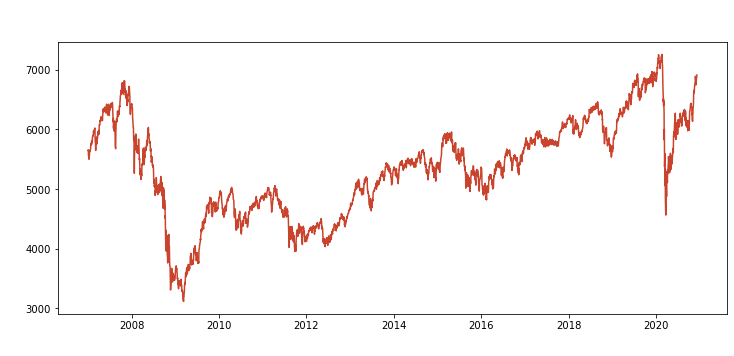



################################################################################




###################################   399001.SZ   ###################################

. Period: from 2007-01-04 to 2020-12-08
. Trading sessions: 3385
. Zero volumes:  0.38%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-04,6954.640137,6705.339844,6730.120117,6659.799805,140800.0
2007-01-05,6777.810059,6706.240234,6667.720215,6585.060059,115100.0
2007-01-08,6872.620117,6870.500000,6693.299805,6691.390137,106400.0
2007-01-09,7095.729980,7078.589844,6894.200195,6848.700195,104200.0
2007-01-10,7346.020020,7346.020020,7110.859863,7100.060059,110500.0
...,...,...,...,...,...
2020-12-02,13991.450195,13961.580078,13950.740234,13858.450195,1850300.0
2020-12-03,14009.509766,13970.679688,13955.980469,13889.620117,1781000.0
2020-12-04,14049.209961,14026.660156,13933.879883,13903.839844,1424800.0



. Statistics:



,high,close,open,low,volume
count,3385.000000,3385.000000,3385.000000,3385.000000,3.385000e+03
mean,10718.350116,10610.240936,10601.071115,10482.957182,3.675186e+05
std,2433.488963,2399.132990,2402.042131,2353.391344,5.519982e+05
min,5767.129883,5668.810059,5589.310059,5577.229980,0.000000e+00
25%,9036.940430,8953.839844,8954.309570,8850.469727,7.200000e+04
50%,10418.240234,10334.759766,10329.200195,10235.700195,1.047000e+05
75%,12052.389648,11917.490234,11903.650391,11752.599609,3.047000e+05
max,19600.029297,19531.150391,19554.580078,19203.109375,3.635400e+06



. Plot:



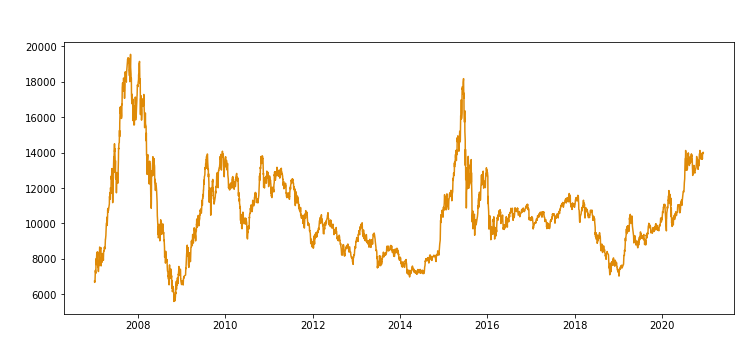



################################################################################




###################################   ^N100   ###################################

. Period: from 2007-01-02 to 2020-12-07
. Trading sessions: 3561
. Zero volumes:  3.65%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-02,974.849976,974.369995,968.549988,968.080017,173960500.0
2007-01-03,974.640015,973.039978,974.640015,970.830017,233721100.0
2007-01-04,969.200012,967.419983,967.700012,964.030029,267755600.0
2007-01-05,966.030029,957.669983,963.700012,957.669983,278706500.0
2007-01-08,963.739990,958.690002,961.299988,957.219971,265474600.0
...,...,...,...,...,...
2020-12-01,1102.189941,1100.709961,1094.150024,1091.290039,245397400.0
2020-12-02,1100.699951,1099.760010,1097.109985,1094.239990,233798900.0
2020-12-03,1102.300049,1101.000000,1101.260010,1095.819946,210670700.0



. Statistics:



,high,close,open,low,volume
count,3561.000000,3561.000000,3561.000000,3561.000000,3.561000e+03
mean,844.905451,839.757775,839.908590,834.267388,2.734494e+08
std,171.960994,172.102692,172.019499,172.213743,1.365823e+08
min,436.519989,434.609985,434.619995,426.619995,0.000000e+00
25%,692.380005,687.890015,687.729980,684.270020,1.911143e+08
50%,860.280029,853.469971,853.080017,847.539978,2.506444e+08
75%,998.369995,993.210022,993.770020,987.919983,3.314816e+08
max,1182.099976,1182.099976,1180.520020,1175.040039,1.159639e+09



. Plot:



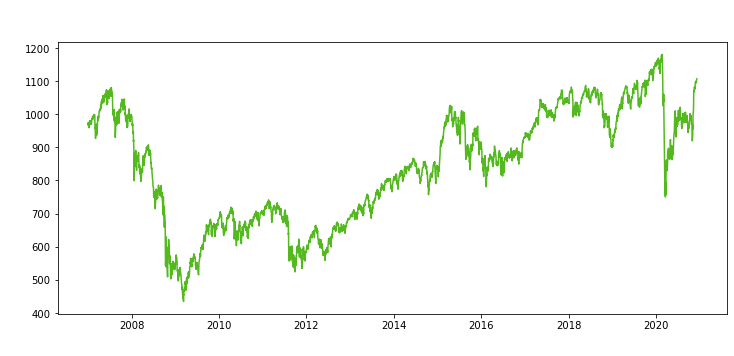



################################################################################




###################################   000001.SS   ###################################

. Period: from 2007-01-04 to 2020-12-08
. Trading sessions: 3387
. Zero volumes:  0.12%
. Data:



,high,close,open,low,volume
date,,,,,
2007-01-04,2847.614990,2715.718994,2728.187988,2684.818115,120200.0
2007-01-05,2685.803955,2641.333984,2668.576904,2617.019043,106200.0
2007-01-08,2708.444092,2707.198975,2621.068115,2620.625000,106800.0
2007-01-09,2809.394043,2807.803955,2711.049072,2691.360107,110800.0
2007-01-10,2841.740967,2825.575928,2838.113037,2770.988037,111800.0
...,...,...,...,...,...
2020-12-02,3465.729004,3449.381104,3453.518066,3435.871094,312800.0
2020-12-03,3452.160889,3442.135986,3448.540039,3428.803955,298500.0
2020-12-04,3448.404053,3444.581055,3436.729004,3417.048096,256300.0



. Statistics:



,high,close,open,low,volume
count,3387.000000,3387.000000,3387.000000,3387.000000,3387.000000
mean,2961.612476,2937.309035,2934.238438,2905.940101,162644.582226
std,720.515740,710.417904,710.531060,696.284121,115881.590415
min,1717.100952,1706.703003,1671.395996,1664.925049,0.000000
25%,2422.158447,2408.301514,2406.201538,2383.535034,88400.000000
50%,2927.072998,2906.333984,2905.052979,2879.656982,131800.000000
75%,3251.169434,3224.255493,3224.479492,3199.668579,193650.000000
max,6124.043945,6092.057129,6057.428223,6040.712891,857100.000000



. Plot:



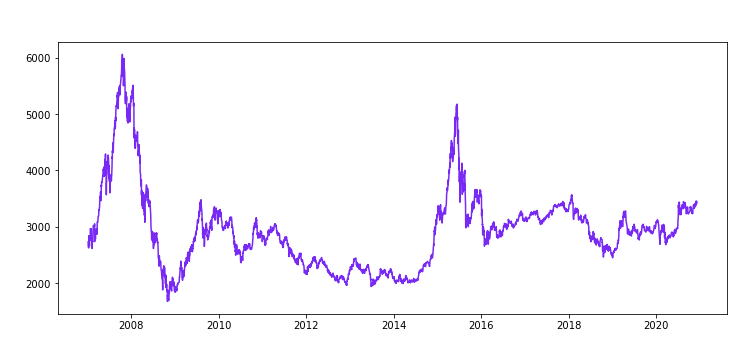



################################################################################


Total number of trading sessions: 93298


In [43]:
visualize = "all"  # "all" or list with specific symbols
total_sessions = 0
for symbol, sdata in multi_data.stocks:
    total_sessions += len(sdata.raw)
    if visualize == "all" or symbol in visualize:
        zero_vols_pc = sdata.raw["volume"].isin([0]).sum() / len(sdata.raw)
        print("\n\n" + "#"*35 + f"   {symbol}   " + "#"*35 + "\n\n" +
              f". Period: from {sdata.raw.index[0]} to {sdata.raw.index[-1]}\n" +
              f". Trading sessions: {len(sdata.raw)}\n" +
              f". Zero volumes: {100*zero_vols_pc : .2f}%\n" 
              f". Data:\n")
        display(sdata.raw)

        print(f"\n. Statistics:\n")
        display(sdata.raw.describe())

        print(f"\n. Plot:\n")
        ax = sdata.raw["open"].plot(figsize=(12,5), color=np.random.rand(1, 3))
        ax.set_title(f"{symbol} opening prices\n", fontsize=16, color="#ffffff");
        ax.set_ylabel("Opening prices", fontsize="14", color="#ffffff");
        ax.set_xlabel("Date", fontsize="14", color="#ffffff");
        plt.show()
        print("\n\n" + "#"*80 + "\n\n")

print(f"Total number of trading sessions: {total_sessions}")

In [44]:
# data division dates
for symbol, data in multi_data.stocks:
    print(f">>>>> {symbol}")
    print(". Training range: %s to %s" % (
        data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
    print(". Validation range: %s to %s" % (
        data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
    print(". Test range: %s to %s\n" % (
        data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))

>>>>> ^AEX
. Training range: 2007-01-02 to 2017-05-30
. Validation range: 2017-05-31 to 2019-07-03
. Test range: 2019-07-04 to 2020-11-23

>>>>> ^OMX
. Training range: 2008-11-20 to 2017-11-13
. Validation range: 2017-11-14 to 2019-09-10
. Test range: 2019-09-11 to 2020-11-23

>>>>> ^ATX
. Training range: 2007-01-02 to 2017-05-29
. Validation range: 2017-05-30 to 2019-07-10
. Test range: 2019-07-11 to 2020-11-23

>>>>> ^IBEX
. Training range: 2007-01-02 to 2017-05-31
. Validation range: 2017-06-01 to 2019-07-03
. Test range: 2019-07-04 to 2020-11-23

>>>>> ^TWII
. Training range: 2007-01-02 to 2017-05-25
. Validation range: 2017-05-26 to 2019-07-01
. Test range: 2019-07-02 to 2020-11-24

>>>>> ^NSEI
. Training range: 2007-09-17 to 2017-08-07
. Validation range: 2017-08-08 to 2019-07-29
. Test range: 2019-07-30 to 2020-11-20

>>>>> ^RUT
. Training range: 2007-01-03 to 2017-05-30
. Validation range: 2017-05-31 to 2019-07-02
. Test range: 2019-07-03 to 2020-11-20

>>>>> ^DJI
. Training ra

In [45]:
# comparing normalized values of the training sets
print("#"*20 + " Normalized training data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_train["features"].tail())

#################### Normalized training data ####################

>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2017-05-24,0.903810,0.906163,0.902700,0.908947,0.128147
2017-05-25,0.904471,0.905032,0.905007,0.903418,0.122561
2017-05-26,0.901525,0.906604,0.899129,0.903172,0.142449
2017-05-29,0.900341,0.905777,0.899816,0.906921,0.066683
2017-05-30,0.899213,0.900207,0.895861,0.900764,0.138642



>>>>> ^OMX


,high,close,open,low,volume
date,,,,,
2017-11-07,0.965938,0.956878,0.967265,0.974090,0.0
2017-11-08,0.958025,0.950587,0.962004,0.962803,0.0
2017-11-09,0.949347,0.933465,0.955679,0.948803,0.0
2017-11-10,0.934390,0.926019,0.938465,0.942681,0.0
2017-11-13,0.924372,0.922400,0.930979,0.928839,0.0



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2017-05-22,0.492148,0.499067,0.489108,0.493910,0.075418
2017-05-23,0.493391,0.496140,0.495282,0.498182,0.075613
2017-05-24,0.495196,0.502070,0.494371,0.498610,0.097337
2017-05-26,0.497038,0.503549,0.500957,0.502451,0.099590
2017-05-29,0.495875,0.496510,0.502461,0.498961,0.060476



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2017-05-25,0.491671,0.498669,0.499642,0.503387,0.234069
2017-05-26,0.485127,0.495315,0.493661,0.491434,0.227936
2017-05-29,0.484785,0.493293,0.488974,0.495769,0.140020
2017-05-30,0.485096,0.492582,0.483849,0.490139,0.275943
2017-05-31,0.489047,0.492892,0.491064,0.496914,0.937626



>>>>> ^TWII


,high,close,open,low,volume
date,,,,,
2017-05-19,0.978309,0.973271,0.985320,0.981641,0.109255
2017-05-22,0.981262,0.981519,0.984447,0.983902,0.086911
2017-05-23,0.988159,0.983277,0.989302,0.989085,0.098425
2017-05-24,0.991787,0.989355,0.992495,0.992619,0.098488
2017-05-25,1.000000,1.000000,1.000000,1.000000,0.126797



>>>>> ^NSEI


,high,close,open,low,volume
date,,,,,
2017-08-01,0.998775,1.000000,0.995351,1.000000,0.353743
2017-08-02,1.000000,0.995633,1.000000,0.998522,0.309981
2017-08-03,0.992493,0.986694,0.992727,0.991361,0.369866
2017-08-04,0.991711,0.993643,0.983159,0.990093,0.342802
2017-08-07,0.993413,0.992458,0.991889,0.997517,0.263724



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2017-05-23,0.960192,0.964271,0.961453,0.961133,0.245180
2017-05-24,0.962985,0.965693,0.964176,0.965334,0.261327
2017-05-25,0.967982,0.966511,0.967580,0.968863,0.274650
2017-05-26,0.960753,0.965442,0.966023,0.964961,0.207769
2017-05-30,0.958409,0.955174,0.964186,0.960115,0.244226



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2017-05-24,0.989883,0.992921,0.987677,0.991919,0.412252
2017-05-25,0.996073,0.997762,0.995477,1.000000,0.390932
2017-05-26,0.994724,0.997579,0.995970,0.999937,0.299455
2017-05-30,0.992704,0.994091,0.994279,0.997133,0.351683
2017-05-31,0.991880,0.992662,0.994483,0.992536,0.544883



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2017-05-26,0.992120,0.994296,0.980244,0.984540,0.034440
2017-05-29,0.998222,0.997821,0.987970,0.989851,0.035188
2017-05-30,0.998482,1.000000,0.995208,0.998144,0.021962
2017-05-31,1.000000,0.999409,1.000000,1.000000,0.030447
2017-06-01,0.998167,0.999052,0.995440,0.998058,0.018717



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2017-05-24,0.988605,0.990454,0.986337,0.987623,0.333463
2017-05-25,0.999052,0.999002,0.992179,0.994754,0.356925
2017-05-26,0.997866,1.000000,0.997045,0.999240,0.311532
2017-05-30,0.999009,0.998583,0.996465,1.000000,0.338641
2017-05-31,1.000000,0.997638,1.000000,0.992636,0.458886



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2017-05-10,1.000000,0.980665,0.990913,0.985967,0.001622
2017-05-11,0.981169,1.000000,0.979667,0.991248,0.001778
2017-05-12,0.980314,0.992376,0.992323,0.999669,0.001286
2017-05-15,0.980904,0.995787,0.986689,0.997672,0.000965
2017-05-16,0.989520,0.999234,1.000000,1.000000,0.001412



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2017-05-24,0.992382,0.993428,0.991810,0.991859,0.226713
2017-05-25,1.000000,0.999569,0.996493,0.997599,0.240661
2017-05-26,0.998822,1.000000,0.999349,1.000000,0.170645
2017-05-30,0.997998,0.998327,0.997719,0.998413,0.208811
2017-05-31,0.998422,0.997689,1.000000,0.995067,0.334679



>>>>> ^BFX


,high,close,open,low,volume
date,,,,,
2017-05-24,0.734717,0.735533,0.740215,0.737523,0.000000
2017-05-25,0.735602,0.732950,0.740990,0.736505,0.000000
2017-05-26,0.730773,0.734982,0.734174,0.730725,0.000000
2017-05-29,0.729518,0.732675,0.733928,0.734532,0.048045
2017-05-30,0.729440,0.731857,0.728699,0.729675,0.000000



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2017-06-01,0.989986,0.999058,0.993161,0.994680,0.214641
2017-06-02,1.000000,1.000000,0.999058,1.000000,0.198343
2017-06-05,0.990828,0.994598,1.000000,0.994877,0.146142
2017-06-06,0.982301,0.994400,0.994598,0.990881,0.209860
2017-06-07,0.989242,0.982902,0.994400,0.984385,0.218633



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2017-05-22,0.734166,0.731319,0.753347,0.730643,0.025039
2017-05-23,0.737394,0.753754,0.731382,0.747929,0.020466
2017-05-24,0.766635,0.767252,0.754141,0.771201,0.018002
2017-05-25,0.766046,0.766571,0.767370,0.773266,0.017226
2017-05-26,0.770264,0.786035,0.766735,0.784079,0.016573



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2017-05-24,0.991542,0.994621,0.995136,0.996001,0.295900
2017-05-25,0.997075,0.997052,1.000000,1.000000,0.308600
2017-05-26,0.992807,0.996052,0.997837,0.999191,0.244848
2017-05-30,0.990228,0.991942,0.995366,0.995307,0.279600
2017-05-31,0.989773,0.991501,0.995891,0.990818,0.394206



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2017-05-18,0.977297,0.976262,0.976401,0.968862,0.219457
2017-05-19,0.979956,0.981582,0.976850,0.980484,0.216359
2017-05-22,0.981238,0.979478,0.982608,0.977691,0.122034
2017-05-23,0.984903,0.983821,0.975237,0.980115,0.153805
2017-05-24,0.980339,0.982040,0.978937,0.982774,0.118795



>>>>> TA35.TA


,high,close,open,low,volume
date,,,,,
2017-05-03,0.708423,0.717134,0.709743,0.719167,0.184219
2017-05-04,0.715163,0.722834,0.715931,0.724110,0.273913
2017-05-07,0.724483,0.734828,0.722111,0.731329,0.178039
2017-05-08,0.726546,0.734828,0.727317,0.735659,0.184876
2017-05-09,0.730834,0.739335,0.731275,0.741625,0.171666



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2017-05-24,0.774522,0.773406,0.774499,0.784553,0.149964
2017-05-25,0.778309,0.772260,0.781094,0.783598,0.124715
2017-05-26,0.770027,0.772118,0.772267,0.772441,0.144804
2017-05-29,0.769756,0.770975,0.771956,0.781838,0.080945
2017-05-30,0.762448,0.763704,0.761882,0.770011,0.147062



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2017-05-24,0.942700,0.939812,0.948600,0.936206,0.257561
2017-05-25,0.946762,0.938759,0.947776,0.937804,0.240655
2017-05-26,0.937717,0.939501,0.943644,0.941145,0.190849
2017-05-29,0.941487,0.940099,0.942605,0.945559,0.073985
2017-05-30,0.937668,0.934175,0.939726,0.940262,0.202563



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2017-05-24,0.915542,0.918552,0.917535,0.917063,0.170195
2017-05-25,0.920460,0.923630,0.914624,0.919232,0.159778
2017-05-26,0.916898,0.914487,0.919045,0.916802,0.141969
2017-05-29,0.912208,0.914178,0.911735,0.912519,0.113071
2017-05-30,0.908946,0.913837,0.910576,0.908397,0.121976



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2017-05-31,0.696187,0.710142,0.705412,0.723873,0.305931
2017-06-01,0.697018,0.717346,0.706862,0.722160,0.205840
2017-06-02,0.703858,0.722914,0.716058,0.733628,0.203099
2017-06-05,0.705128,0.719953,0.718496,0.731211,0.180238
2017-06-06,0.706135,0.726458,0.710894,0.731365,0.157201



>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2017-05-29,0.986251,0.985204,0.991974,0.984491,0.016943
2017-05-30,0.984212,0.979983,0.985206,0.977195,0.056926
2017-05-31,0.977818,0.965172,0.979868,0.967032,0.185708
2017-06-01,0.971780,0.974648,0.965363,0.967780,0.087414
2017-06-02,0.974792,0.981176,0.974582,0.973913,0.070918



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2017-05-30,0.703404,0.706673,0.712186,0.709215,0.112462
2017-05-31,0.706505,0.708089,0.714460,0.716443,0.202620
2017-06-01,0.705970,0.711083,0.715894,0.716335,0.145299
2017-06-02,0.719981,0.724071,0.718925,0.723240,0.133100
2017-06-05,0.718724,0.716321,0.732105,0.723941,0.134962



>>>>> 399001.SZ


,high,close,open,low,volume
date,,,,,
2017-05-22,0.307080,0.305204,0.312846,0.314675,0.224513
2017-05-23,0.299819,0.295403,0.307124,0.307069,0.250806
2017-05-24,0.292443,0.298914,0.295929,0.295921,0.204474
2017-05-25,0.300059,0.304780,0.300946,0.304588,0.258815
2017-05-26,0.299746,0.302288,0.306644,0.312748,0.224481



>>>>> ^N100


,high,close,open,low,volume
date,,,,,
2017-05-24,0.920273,0.922633,0.916783,0.925051,0.00000
2017-05-25,0.924249,0.923193,0.923674,0.925005,0.00000
2017-05-26,0.918612,0.923069,0.916040,0.916502,0.00000
2017-05-29,0.917618,0.920580,0.916225,0.924232,0.07592
2017-05-30,0.911950,0.914638,0.906005,0.914028,0.00000



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2017-05-23,0.310223,0.309039,0.318739,0.316724,0.208027
2017-05-24,0.305816,0.309524,0.313762,0.310202,0.163108
2017-05-25,0.317126,0.319502,0.315535,0.317179,0.223311
2017-05-26,0.318489,0.320010,0.326010,0.328047,0.181892
2017-05-31,0.323621,0.321633,0.331491,0.330599,0.178509


In [46]:
# comparing normalized values of the validation sets
print("#"*20 + " Normalized validation data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_val["features"].tail())

#################### Normalized validation data ####################

>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2019-06-27,0.988740,0.987950,0.988905,0.983579,0.128821
2019-06-28,0.995045,0.999614,0.984950,0.992693,0.125462
2019-07-01,1.019739,1.017565,1.015791,1.021101,0.128970
2019-07-02,1.018775,1.022501,1.017604,1.019185,0.125316
2019-07-03,1.025273,1.030415,1.017274,1.025562,0.111350



>>>>> ^OMX


,high,close,open,low,volume
date,,,,,
2019-09-04,0.881171,0.879678,0.873947,0.885669,0.0
2019-09-05,0.891660,0.893615,0.884948,0.896745,0.0
2019-09-06,0.895497,0.897615,0.898663,0.907241,0.0
2019-09-09,0.902975,0.905209,0.902764,0.913090,0.0
2019-09-10,0.915605,0.917601,0.910319,0.918518,0.0



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2019-07-04,0.449007,0.454091,0.447517,0.453184,0.037385
2019-07-05,0.450462,0.452738,0.453987,0.454245,0.037031
2019-07-08,0.451273,0.451469,0.452749,0.457503,0.039505
2019-07-09,0.444725,0.441029,0.451318,0.443618,0.044653
2019-07-10,0.439681,0.443735,0.441038,0.442989,0.048876



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2019-06-27,0.312014,0.319489,0.320197,0.323236,0.173775
2019-06-28,0.313975,0.324594,0.318287,0.322504,0.192766
2019-07-01,0.323827,0.331181,0.332368,0.332440,0.190341
2019-07-02,0.322228,0.332873,0.331741,0.333032,0.159802
2019-07-03,0.333196,0.344175,0.332388,0.338422,0.171495



>>>>> ^TWII


,high,close,open,low,volume
date,,,,,
2019-06-25,1.114409,1.099397,1.117639,1.103844,0.102803
2019-06-26,1.098128,1.090397,1.098648,1.096034,0.078487
2019-06-27,1.116543,1.110560,1.100749,1.100757,0.148063
2019-06-28,1.114486,1.103403,1.119194,1.108110,0.092741
2019-07-01,1.135842,1.130757,1.124875,1.124857,0.153416



>>>>> ^NSEI


,high,close,open,low,volume
date,,,,,
2019-07-23,1.166871,1.160254,1.162996,1.158332,0.880806
2019-07-24,1.161786,1.152382,1.156429,1.148989,0.793090
2019-07-25,1.162005,1.149859,1.152202,1.150211,1.062764
2019-07-26,1.154881,1.154095,1.146538,1.146461,1.003263
2019-07-29,1.155325,1.141566,1.154457,1.139082,0.926871



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2019-06-26,1.097539,1.095208,1.096709,1.099301,0.269407
2019-06-27,1.112875,1.118123,1.092624,1.098218,0.236878
2019-06-28,1.133470,1.136726,1.119895,1.125517,0.447297
2019-07-01,1.150441,1.136726,1.144639,1.139204,0.272625
2019-07-02,1.134339,1.131122,1.139863,1.130008,0.244563



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2019-06-27,1.376094,1.371420,1.369966,1.371287,0.357864
2019-06-28,1.378245,1.376457,1.375604,1.375193,0.736583
2019-07-01,1.395694,1.384520,1.389315,1.381635,0.388981
2019-07-02,1.388565,1.389273,1.383394,1.382763,0.316364
2019-07-03,1.400905,1.401582,1.391129,1.396396,0.212195



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2019-06-25,1.358121,1.359822,1.342122,1.334837,0.026204
2019-06-26,1.366104,1.366654,1.352814,1.350796,0.035438
2019-06-27,1.372322,1.366408,1.363837,1.358946,0.030946
2019-06-28,1.366148,1.358069,1.363688,1.352602,0.025955
2019-07-01,1.370043,1.370760,1.359934,1.360255,0.024956



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2019-06-27,1.357653,1.355672,1.347945,1.351590,0.415886
2019-06-28,1.364496,1.363459,1.357951,1.356857,0.890445
2019-07-01,1.393095,1.380644,1.389772,1.376681,0.458770
2019-07-02,1.384721,1.384272,1.377780,1.377455,0.398158
2019-07-03,1.397127,1.396645,1.386474,1.389457,0.306258



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2019-06-27,0.865899,0.880637,0.866175,0.880993,0.002473
2019-06-28,0.864403,0.877911,0.876486,0.885124,0.002061
2019-07-01,0.870299,0.877263,0.885249,0.887208,0.001581
2019-07-02,0.858226,0.871577,0.867140,0.876897,0.001767
2019-07-03,0.855905,0.852426,0.866190,0.863101,0.002005



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2019-06-27,1.296262,1.292706,1.290281,1.290115,0.201119
2019-06-28,1.304780,1.302388,1.297930,1.296120,0.421398
2019-07-01,1.324479,1.315364,1.320085,1.309394,0.238540
2019-07-02,1.321740,1.320355,1.316198,1.311514,0.209164
2019-07-03,1.334871,1.333469,1.323927,1.324142,0.089991



>>>>> ^BFX


,high,close,open,low,volume
date,,,,,
2019-06-27,0.611681,0.615008,0.611656,0.612532,0.104976
2019-06-28,0.619870,0.625533,0.613503,0.619087,0.083021
2019-07-01,0.635759,0.635033,0.634193,0.639526,0.086094
2019-07-02,0.638965,0.640808,0.642255,0.642280,0.086558
2019-07-03,0.649291,0.654568,0.642532,0.647315,0.081708



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2019-07-01,0.982946,0.987585,0.969768,0.971956,0.153710
2019-07-02,0.991646,1.002875,0.987585,0.989582,0.132522
2019-07-03,1.005453,1.015289,1.002875,1.004535,0.166666
2019-07-04,1.005850,1.013877,1.015289,1.015027,0.113939
2019-07-05,1.001140,1.001363,1.013877,1.000466,0.130972



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2019-06-27,1.638666,1.617191,1.616769,1.623843,0.017888
2019-06-28,1.651343,1.622703,1.617608,1.654122,0.017566
2019-07-01,1.671819,1.631165,1.623213,1.659853,0.001772
2019-07-02,1.651390,1.614491,1.631586,1.638971,0.021319
2019-07-03,1.665811,1.647112,1.614205,1.647741,0.020671



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2019-06-27,1.174811,1.175402,1.171368,1.173202,0.272596
2019-06-28,1.185621,1.186753,1.178581,1.180390,0.473166
2019-07-01,1.204088,1.197241,1.189931,1.191699,0.306669
2019-07-02,1.198800,1.200585,1.200448,1.199133,0.279921
2019-07-03,1.210603,1.212329,1.203800,1.205519,0.171411



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2019-06-26,0.942441,0.938547,0.932925,0.936158,-0.030366
2019-06-27,0.944491,0.941360,0.943611,0.938318,-0.030366
2019-06-28,0.952553,0.955338,0.943011,0.947928,-0.030366
2019-07-01,0.975701,0.968748,0.977292,0.972057,-0.030366
2019-07-02,0.967879,0.969332,0.969704,0.968243,-0.030366



>>>>> TA35.TA


,high,close,open,low,volume
date,,,,,
2019-06-05,0.840766,0.842606,0.838890,0.845611,0.384578
2019-06-06,0.840703,0.838903,0.844123,0.844109,0.254735
2019-06-10,0.847009,0.855270,0.848612,0.855667,0.151299
2019-06-11,0.847516,0.850012,0.850356,0.854431,0.149896
2019-06-12,0.833944,0.840220,0.835420,0.844447,0.228278



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2019-06-27,0.818285,0.815137,0.821614,0.822676,0.128863
2019-06-28,0.827645,0.827568,0.816883,0.828341,0.146807
2019-07-01,0.845963,0.835499,0.842437,0.850725,0.132992
2019-07-02,0.838115,0.837941,0.840856,0.847668,0.127197
2019-07-03,0.848045,0.849449,0.841092,0.853777,0.119147



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2019-06-25,1.069316,1.053725,1.072096,1.060812,0.260465
2019-06-26,1.054657,1.046652,1.058876,1.052591,0.265360
2019-06-27,1.045649,1.046113,1.048462,1.048511,0.223140
2019-06-28,1.053239,1.055030,1.051090,1.052615,0.261498
2019-07-02,1.064199,1.065693,1.067200,1.062053,0.224103



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2019-06-21,1.039353,1.028278,1.040912,1.027701,0.149530
2019-06-24,1.026361,1.030258,1.021857,1.025099,0.072581
2019-06-25,1.026066,1.023585,1.022904,1.019955,0.090558
2019-06-26,1.012773,1.015823,1.010611,1.014275,0.084509
2019-06-27,1.027827,1.034036,1.017047,1.020642,0.102991



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2019-07-03,0.848277,0.865046,0.854500,0.872341,0.131777
2019-07-04,0.854021,0.862167,0.859833,0.875013,0.094748
2019-07-05,0.847717,0.861151,0.854673,0.872037,0.086428
2019-07-08,0.830921,0.839663,0.841469,0.846858,0.127652
2019-07-09,0.819634,0.829218,0.831123,0.841379,0.124345



>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2019-06-27,0.809351,0.799600,0.816496,0.803071,0.067536
2019-06-28,0.795522,0.794898,0.801340,0.795019,0.087733
2019-07-01,0.799791,0.803282,0.796717,0.795315,0.059410
2019-07-02,0.804530,0.803390,0.805331,0.805570,0.058159
2019-07-03,0.800113,0.804643,0.805280,0.803870,0.042566



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2019-07-03,0.974386,0.977685,0.981056,0.982092,0.148215
2019-07-04,0.984385,0.985916,0.988904,0.992287,0.129780
2019-07-05,0.993824,0.994174,0.997240,0.999784,0.134037
2019-07-08,0.988931,0.974291,1.002923,0.988862,0.114704
2019-07-09,0.970856,0.972340,0.985467,0.980798,0.129089



>>>>> 399001.SZ


,high,close,open,low,volume
date,,,,,
2019-06-26,0.245585,0.249137,0.248819,0.254155,0.018571
2019-06-27,0.253547,0.257581,0.255257,0.262398,0.024730
2019-06-28,0.250774,0.253168,0.261130,0.260509,0.021507
2019-07-01,0.272056,0.278571,0.271780,0.276132,0.042950
2019-07-02,0.274230,0.279658,0.281205,0.286655,0.035834



>>>>> ^N100


,high,close,open,low,volume
date,,,,,
2019-06-27,0.977188,0.976451,0.976014,0.974569,0.146487
2019-06-28,0.987204,0.990543,0.971693,0.982237,0.157230
2019-07-01,1.007516,1.001011,1.000883,1.006849,0.152561
2019-07-02,1.002640,1.006128,1.000573,1.005658,0.143830
2019-07-03,1.017781,1.022180,1.002756,1.013481,0.135610



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2019-06-26,0.288139,0.289505,0.294849,0.295613,0.203477
2019-06-27,0.293727,0.294181,0.298953,0.300773,0.227978
2019-06-28,0.289348,0.290096,0.301148,0.296243,0.211644
2019-07-01,0.301403,0.305152,0.308531,0.308461,0.283864
2019-07-02,0.302110,0.304933,0.312625,0.312825,0.242795


In [47]:
# comparing normalized values of the test sets
print("#"*20 + " Normalized test data " + "#"*20)
for symbol, data in multi_data.stocks:
    print(f"\n>>>>> {symbol}")
    display(data.norm_test["features"].tail())

#################### Normalized test data ####################

>>>>> ^AEX


,high,close,open,low,volume
date,,,,,
2020-11-17,1.103816,1.107652,1.099141,1.099674,0.000210
2020-11-18,1.109542,1.107486,1.095817,1.101891,0.000192
2020-11-19,1.093520,1.094058,1.089336,1.091929,0.000191
2020-11-20,1.103733,1.109527,1.088485,1.095076,0.000164
2020-11-23,1.119260,1.108838,1.115838,1.112181,0.210825



>>>>> ^OMX


,high,close,open,low,volume
date,,,,,
2020-11-17,1.182343,1.175533,1.173987,1.185931,0.0
2020-11-18,1.185230,1.175819,1.175234,1.185747,0.0
2020-11-19,1.179172,1.169632,1.169075,1.180398,0.0
2020-11-20,1.189155,1.179238,1.172538,1.184508,0.0
2020-11-23,1.195461,1.175160,1.190345,1.195241,0.0



>>>>> ^ATX


,high,close,open,low,volume
date,,,,,
2020-11-17,0.297854,0.304307,0.300667,0.300844,0.052253
2020-11-18,0.302342,0.307945,0.304202,0.306068,0.054480
2020-11-19,0.301003,0.305615,0.305684,0.305670,0.061233
2020-11-20,0.305388,0.305531,0.305463,0.311153,0.044828
2020-11-23,0.312407,0.312175,0.305513,0.312721,0.053170



>>>>> ^IBEX


,high,close,open,low,volume
date,,,,,
2020-11-17,0.189589,0.198010,0.201875,0.193761,0.543351
2020-11-18,0.191127,0.202735,0.195416,0.199071,0.375414
2020-11-19,0.189569,0.197599,0.194730,0.196581,0.331362
2020-11-20,0.191811,0.202375,0.197874,0.202212,0.294686
2020-11-23,0.198466,0.202705,0.206861,0.207451,0.352522



>>>>> ^TWII


,high,close,open,low,volume
date,,,,,
2020-11-18,1.617385,1.608916,1.585268,1.581529,0.346615
2020-11-19,1.619513,1.600466,1.609351,1.596490,0.329343
2020-11-20,1.609456,1.599471,1.597433,1.590925,0.318513
2020-11-23,1.642296,1.626316,1.612351,1.611810,0.377995
2020-11-24,1.647352,1.614539,1.632900,1.612592,0.451711



>>>>> ^NSEI


,high,close,open,low,volume
date,,,,,
2020-11-13,1.344003,1.343234,1.332784,1.325349,0.986372
2020-11-17,1.370233,1.363555,1.368761,1.349590,1.358349
2020-11-18,1.372192,1.371994,1.359212,1.352438,1.403647
2020-11-19,1.374066,1.350052,1.356496,1.343018,1.475624
2020-11-20,1.364725,1.361559,1.353054,1.341034,1.274472



>>>>> ^RUT


,high,close,open,low,volume
date,,,,,
2020-11-16,1.335908,1.340011,1.305403,1.311216,0.434594
2020-11-17,1.345762,1.346116,1.339044,1.318983,0.390417
2020-11-18,1.354458,1.325125,1.348063,1.332035,0.433904
2020-11-19,1.335254,1.338887,1.326136,1.327255,0.348992
2020-11-20,1.337823,1.340011,1.338168,1.333725,0.337249



>>>>> ^DJI


,high,close,open,low,volume
date,,,,,
2020-11-16,1.608263,1.606438,1.585894,1.591227,0.614965
2020-11-17,1.601910,1.594968,1.594658,1.580798,0.546083
2020-11-18,1.605950,1.571292,1.599818,1.574800,0.561792
2020-11-19,1.577876,1.574368,1.565222,1.560779,0.484494
2020-11-20,1.574071,1.559284,1.569793,1.560972,0.445515



>>>>> ^BSESN


,high,close,open,low,volume
date,,,,,
2020-11-13,1.533438,1.534093,1.522364,1.510288,0.058897
2020-11-17,1.561221,1.556255,1.556835,1.537877,0.050162
2020-11-18,1.563584,1.566140,1.551763,1.541574,0.043674
2020-11-19,1.564215,1.540917,1.548461,1.530140,0.058148
2020-11-20,1.554779,1.553191,1.541103,1.527391,0.040679



>>>>> ^IXIC


,high,close,open,low,volume
date,,,,,
2020-11-16,2.165087,2.156305,2.139502,2.137711,0.904279
2020-11-17,2.167627,2.151289,2.152919,2.145314,0.900551
2020-11-18,2.166059,2.131509,2.149417,2.134686,1.033600
2020-11-19,2.159972,2.152375,2.125713,2.126787,1.177505
2020-11-20,2.164628,2.142310,2.148736,2.145334,1.176757



>>>>> ^KS11


,high,close,open,low,volume
date,,,,,
2020-11-18,1.170053,1.183608,1.174202,1.181751,0.003542
2020-11-19,1.166368,1.184919,1.165597,1.176542,0.003745
2020-11-20,1.173193,1.189398,1.170756,1.183914,0.004330
2020-11-23,1.208106,1.225556,1.182253,1.193909,0.006324
2020-11-24,1.225013,1.236730,1.222717,1.230793,0.005233



>>>>> ^GSPC


,high,close,open,low,volume
date,,,,,
2020-11-16,1.701968,1.696313,1.682195,1.680619,0.408100
2020-11-17,1.698835,1.686320,1.688041,1.674042,0.361853
2020-11-18,1.696502,1.662322,1.689066,1.661810,0.407378
2020-11-19,1.676850,1.670417,1.658727,1.648352,0.318486
2020-11-20,1.674535,1.656429,1.670188,1.655806,0.306193



>>>>> ^BFX


,high,close,open,low,volume
date,,,,,
2020-11-17,0.634560,0.639479,0.636339,0.636625,0.000135
2020-11-18,0.641190,0.646434,0.635447,0.638389,0.000131
2020-11-19,0.633064,0.633345,0.634313,0.634887,0.000138
2020-11-20,0.635003,0.637361,0.631397,0.636460,0.000111
2020-11-23,0.647264,0.646180,0.646887,0.649474,0.124154



>>>>> ^FTSE


,high,close,open,low,volume
date,,,,,
2020-11-17,0.708864,0.707025,0.720902,0.698233,0.313566
2020-11-18,0.701775,0.711956,0.707025,0.702572,0.247114
2020-11-19,0.699123,0.699368,0.711956,0.699532,0.233387
2020-11-20,0.699494,0.703605,0.699368,0.702057,0.204179
2020-11-23,0.700833,0.699219,0.703605,0.702204,0.237362



>>>>> ^BVSP


,high,close,open,low,volume
date,,,,,
2020-11-16,1.768096,1.746631,1.708441,1.747001,0.050478
2020-11-17,1.798539,1.764757,1.747039,1.772941,0.044393
2020-11-18,1.790457,1.747834,1.765555,1.781526,0.044506
2020-11-19,1.778817,1.748605,1.739936,1.765934,0.036836
2020-11-23,1.791117,1.768159,1.738416,1.777651,0.041702



>>>>> ^NYA


,high,close,open,low,volume
date,,,,,
2020-11-16,1.311817,1.312172,1.310831,1.303166,0.461057
2020-11-17,1.312337,1.307721,1.302014,1.295046,0.418948
2020-11-18,1.314410,1.288831,1.316255,1.293650,0.460400
2020-11-19,1.296308,1.296172,1.286466,1.281005,0.379462
2020-11-20,1.297963,1.291299,1.298280,1.293901,0.368269



>>>>> ^GDAXI


,high,close,open,low,volume
date,,,,,
2020-11-17,1.033864,1.035712,1.033507,1.029867,0.112688
2020-11-18,1.040718,1.043197,1.028685,1.032507,0.110711
2020-11-19,1.032454,1.030536,1.030355,1.028136,0.111543
2020-11-20,1.036260,1.036126,1.025209,1.030327,0.115899
2020-11-23,1.051532,1.035001,1.042789,1.038200,0.112678



>>>>> TA35.TA


,high,close,open,low,volume
date,,,,,
2020-11-15,0.729785,0.737435,0.731151,0.739393,0.035966
2020-11-16,0.746487,0.743232,0.739340,0.744114,0.146564
2020-11-17,0.739656,0.737249,0.739128,0.738273,0.109721
2020-11-18,0.738254,0.743939,0.736312,0.744372,0.096424
2020-11-19,0.728409,0.733696,0.733072,0.736202,0.103232



>>>>> ^FCHI


,high,close,open,low,volume
date,,,,,
2020-11-17,0.811671,0.812229,0.810594,0.815996,0.000000
2020-11-18,0.820993,0.820026,0.810561,0.818974,0.000000
2020-11-19,0.812465,0.809943,0.807771,0.818242,0.000000
2020-11-20,0.821889,0.815762,0.809412,0.821516,0.000000
2020-11-23,0.830624,0.814737,0.831359,0.829951,0.180682



>>>>> ^GSPTSE


,high,close,open,low,volume
date,,,,,
2020-11-17,1.122421,1.122757,1.107398,1.108225,0.332174
2020-11-18,1.127004,1.115780,1.127951,1.122077,0.320483
2020-11-19,1.118759,1.118174,1.111913,1.113582,0.281279
2020-11-20,1.134072,1.131255,1.122828,1.122888,0.289327
2020-11-23,1.144790,1.140279,1.139297,1.140081,0.348551



>>>>> ^N225


,high,close,open,low,volume
date,,,,,
2020-11-17,1.368511,1.372589,1.369592,1.362147,0.142473
2020-11-18,1.355866,1.351849,1.356397,1.348072,0.116263
2020-11-19,1.339169,1.345059,1.339672,1.334943,0.137769
2020-11-20,1.332275,1.337314,1.329434,1.331378,0.106519
2020-11-24,1.383273,1.383519,1.359347,1.365752,0.137265



>>>>> ^HSI


,high,close,open,low,volume
date,,,,,
2020-11-18,0.735772,0.752990,0.740692,0.757462,0.233976
2020-11-19,0.727984,0.743907,0.741971,0.755856,0.246337
2020-11-20,0.733112,0.748493,0.739366,0.755935,0.219342
2020-11-23,0.737981,0.750173,0.751626,0.758645,0.228098
2020-11-24,0.736382,0.755119,0.750198,0.760600,0.205630



>>>>> ^MXX


,high,close,open,low,volume
date,,,,,
2020-11-17,0.753362,0.758213,0.727969,0.733120,0.161120
2020-11-18,0.772606,0.767406,0.761122,0.757087,0.120967
2020-11-19,0.759686,0.755793,0.767017,0.753005,0.113472
2020-11-20,0.757178,0.756890,0.757896,0.758043,0.068144
2020-11-23,0.764419,0.767848,0.759242,0.760910,0.070901



>>>>> ^AORD


,high,close,open,low,volume
date,,,,,
2020-11-18,0.963931,0.966033,0.969338,0.971898,0.200794
2020-11-19,0.965108,0.970363,0.977105,0.972140,0.188853
2020-11-20,0.970322,0.969614,0.981489,0.982820,0.171717
2020-11-23,0.992514,0.996659,0.989418,0.992799,0.037244
2020-11-24,0.999385,1.000508,0.989418,0.992799,0.228391



>>>>> 399001.SZ


,high,close,open,low,volume
date,,,,,
2020-11-18,0.578798,0.576338,0.581493,0.588987,0.458853
2020-11-19,0.581632,0.584940,0.576048,0.587199,0.422222
2020-11-20,0.585459,0.590348,0.587219,0.601501,0.412489
2020-11-23,0.596720,0.597768,0.593071,0.603168,0.566834
2020-11-24,0.592443,0.593964,0.599251,0.607057,0.487157



>>>>> ^N100


,high,close,open,low,volume
date,,,,,
2020-11-17,1.003339,1.005382,1.002942,1.001902,0.214351
2020-11-18,1.011569,1.011821,0.994828,1.003772,0.199330
2020-11-19,0.999099,1.000047,0.991762,0.999552,0.206300
2020-11-20,1.009799,1.009877,0.993605,1.003324,0.181708
2020-11-23,1.022735,1.008586,1.018520,1.014811,0.205430



>>>>> 000001.SS


,high,close,open,low,volume
date,,,,,
2020-11-18,0.372547,0.374109,0.379828,0.381432,0.335433
2020-11-19,0.374462,0.377708,0.380227,0.380623,0.295531
2020-11-20,0.377370,0.381047,0.384905,0.386533,0.304865
2020-11-23,0.389056,0.389430,0.390491,0.391487,0.436238
2020-11-24,0.385034,0.386769,0.395805,0.395659,0.351184


In [48]:
# sample output shape
sample_x, sample_y = next(iter(multi_data.tf_datasets["train"]))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (135, 10, 5)
Sample label shape: (135, 3)


## **2) Defining a model**

In [49]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS, load_path=None):
        super(MultiLSTM, self).__init__()
        if load_path is not None:
            self.custom_load(load_path)
        else:
            self._num_sessions = num_sessions
            self._open_predictor = model = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                #tf.keras.layers.Dense(128, activation="relu"),  
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation="relu"),
            ])

            self._pre_lowest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True)
            ])
            self._lowest_predictor = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                #tf.keras.layers.Dense(128, activation="relu"),  
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation="relu"),
            ])

            self._pre_highest = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True)
            ])
            self._highest_predictor = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=True),
                tf.keras.layers.Dropout(0.25),
                tf.keras.layers.LSTM(32, return_sequences=False),
                tf.keras.layers.BatchNormalization(),
                #tf.keras.layers.Dense(128, activation="relu"),  
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(1, activation="relu"),
            ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)
    
    def custom_save(self, dir_path):
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
            
        with open(os.path.join(dir_path, "info.txt"), "w") as file:
            file.write("num_sessions %d" % self._num_sessions)
        
        pred_dir = os.path.join(dir_path, "predictors")
        if not os.path.isdir(pred_dir):
            os.makedirs(pred_dir)
            
        pre_dir = os.path.join(dir_path, "pre_layers")
        if not os.path.isdir(pre_dir):
            os.makedirs(pre_dir)
            
        # saving predictors
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor"))
        self._open_predictor.save(os.path.join(pred_dir, "open_predictor.h5"))
        
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor"))
        self._lowest_predictor.save(os.path.join(pred_dir, "low_predictor.h5"))
        
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor"))
        self._highest_predictor.save(os.path.join(pred_dir, "high_predictor.h5"))
        
        # saving pre-layers
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low"))
        self._pre_lowest.save(os.path.join(pred_dir, "pre_low.h5"))
        
        self._pre_highest.save(os.path.join(pred_dir, "pre_high"))
        self._pre_highest.save(os.path.join(pred_dir, "pre_high.h5"))
    
    def custom_load(self, dir_path):
        with open(os.path.join(dir_path, "info.txt"), "r") as file:
            self._num_sessions = int(file.readline().split()[1])
            
        pred_dir = os.path.join(dir_path, "predictors")
        pre_dir = os.path.join(dir_path, "pre_layers")
        
        # loading predictors
        self._open_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "open_predictor"))
        self._lowest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "low_predictor"))
        self._highest_predictor = tf.keras.models.load_model(os.path.join(pred_dir, "high_predictor"))
        
        # saving pre-layers
        self._pre_lowest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_low"))
        self._pre_highest = tf.keras.models.load_model(os.path.join(pred_dir, "pre_high"))

In [50]:
# testing output shape
x, y = next(iter(multi_data.tf_datasets["train"]))
MultiLSTM()(x).shape

TensorShape([135, 3])

## **3) Training the model**

In [51]:
# loading all validation data into memory (so we dont have to use a generator)
val_inputs, val_outputs = [], []
for x, y in multi_data.tf_datasets["val"]:
    val_inputs.append(x)
    val_outputs.append(y)

val_inputs = tf.concat(val_inputs, axis=0)
val_outputs = tf.concat(val_outputs, axis=0)

print(val_inputs.shape, val_outputs.shape)

(13740, 10, 5) (13740, 3)



Epoch 00020: val_loss did not improve from 0.00214


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/full_save/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/full_save/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/open_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/open_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/low_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/low_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/high_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/high_predictor/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/pre_low/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/pre_low/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/pre_high/assets


INFO:tensorflow:Assets written to: saved_model_2020-12-10-11-57-16/predictors/pre_high/assets


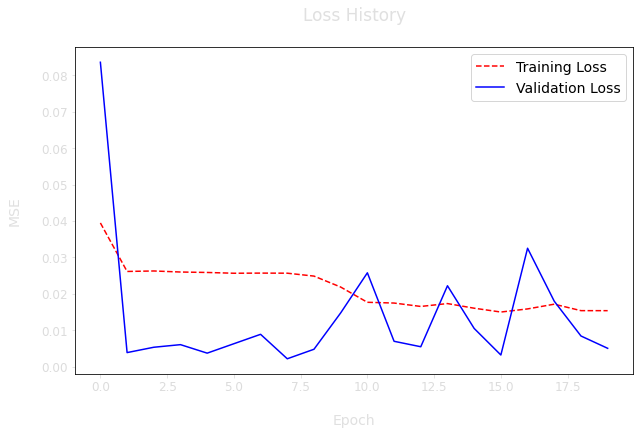

In [52]:
save_path = f"saved_model_{datetime.today().strftime('%Y-%m-%d-%H-%M-%S')}"
tf.keras.backend.clear_session()

# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=[])
                       #tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 20
history = model.fit(
    multi_data.tf_datasets["train"].shuffle(buffer_size=multi_data.size["train"]), 
    epochs=epochs,
    validation_data=(val_inputs, val_outputs),
    callbacks=[ClearCallback(),
               ModelCheckpoint(filepath=os.path.join(save_path, "checkpoint_best"), 
                                                     monitor='val_loss', 
                                                     verbose=1, save_best_only=True)],
)

# restoring the checkpoint of the best model
model.load_weights(os.path.join(save_path, "checkpoint_best"))

# saving and downloading the model
model.save(os.path.join(save_path, "full_save"))
model.custom_save(save_path)
shutil.make_archive(save_path, "zip", save_path)

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

In [ ]:
#model = MultiLSTM(load_path="saved_model_2020-12-10-01-42-11")
#model.compile(loss=tf.losses.MeanSquaredError(),
              #optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              #metrics=[])

## **4) Evaluating on all the stocks**

In [53]:
loss = {}
for mode in ["train", "val", "test"]:
    loss[mode] = model.evaluate(multi_data.tf_datasets[mode])

loss = pd.Series(loss.values(), index=loss.keys())
print("\n\n>>> Loss value (on the normalized data):")
loss

70/70 [==============================] - 2s 26ms/step - loss: 0.0087


>>> Loss value (on the normalized data):


train    0.004001
val      0.002137
test     0.008716
dtype: float64

## **5) Evaluating on individual stocks**

In [56]:
results, predictions = {}, {}
for i, stk in enumerate(STOCKS.keys()):
    clear_output(wait=True)
    print(f"[{100*(i+1) / len(STOCKS) : .2f}%] Evaluating stock {i+1} of {len(STOCKS)}... ", end="")

    results[stk], predictions[stk] = {}, {}
    for mode in ["train", "val", "test"]:
        predictions[stk][mode], results[stk][mode] = eval(model, 
                                                          multi_data[stk], mode)
    print("done!")

[ 100.000000%] Evaluating stock 27 of 27... done!


#### **5.1) Training data**

In [57]:
symbol = "^BVSP"

     Training Data

#########################

[> GENERAL <]
   . MAE:   2157
   . MAPE:  4.1379%
   . MSE:   6082946

#########################

[> OPEN <]
   . MAE:   2486
   . MAPE:  4.6534%
   . MSE:   6629722
   . Tendency Accuracy:  48.3594%

#########################

[> LOW <]
   . MAE:   2379
   . MAPE:  4.5767%
   . MSE:   7051507
   . Tendency Accuracy:  45.1953%

#########################

[> HIGH <]
   . MAE:   1605
   . MAPE:  3.1837%
   . MSE:   4567609
   . Tendency Accuracy:  51.4844%

#########################


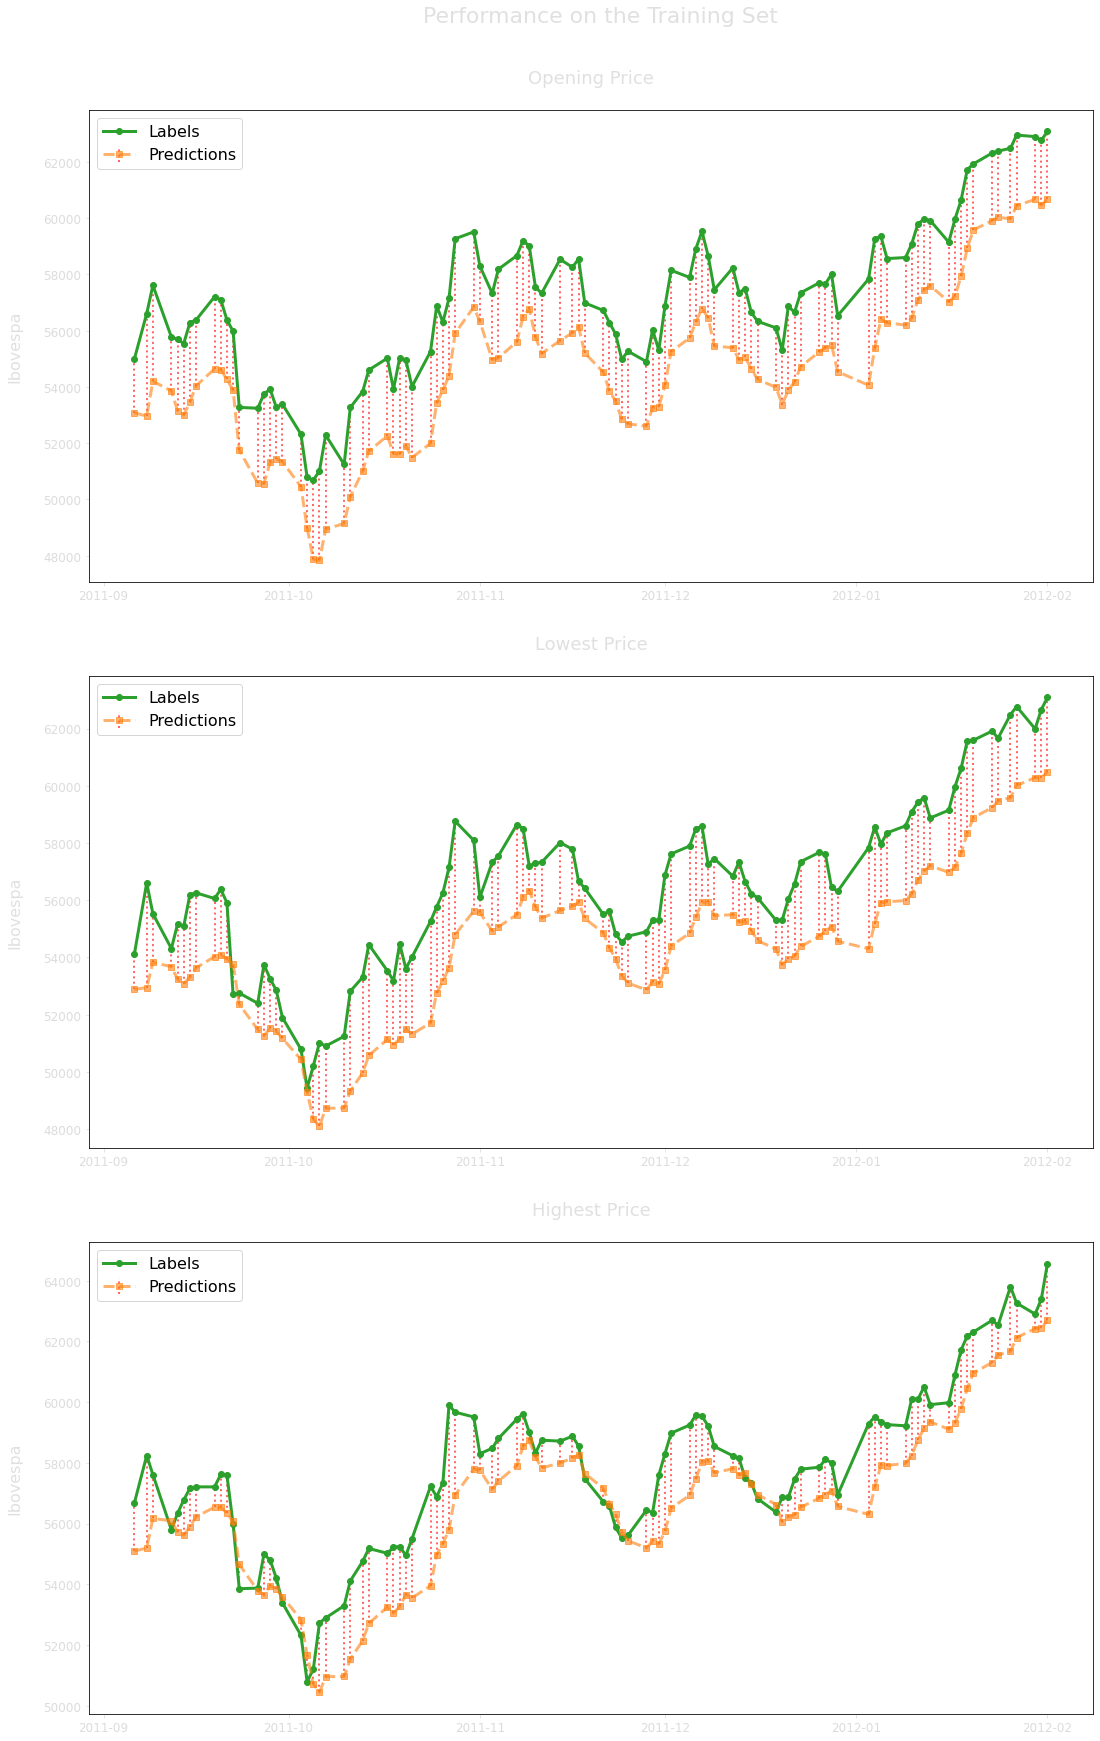

In [58]:
print("     Training Data\n")
eval_print(results[symbol]["train"])
eval_plot(predictions[symbol]["train"], 
          multi_data[symbol].raw_train["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Training Set")

#### **5.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   1665
   . MAPE:  2.0215%
   . MSE:   5160436

#########################

[> OPEN <]
   . MAE:   915
   . MAPE:  1.2062%
   . MSE:   1252918
   . Tendency Accuracy:  65.0198%

#########################

[> LOW <]
   . MAE:   3149
   . MAPE:  3.7316%
   . MSE:   12851504
   . Tendency Accuracy:  41.8972%

#########################

[> HIGH <]
   . MAE:   931
   . MAPE:  1.1268%
   . MSE:   1376887
   . Tendency Accuracy:  49.6047%

#########################


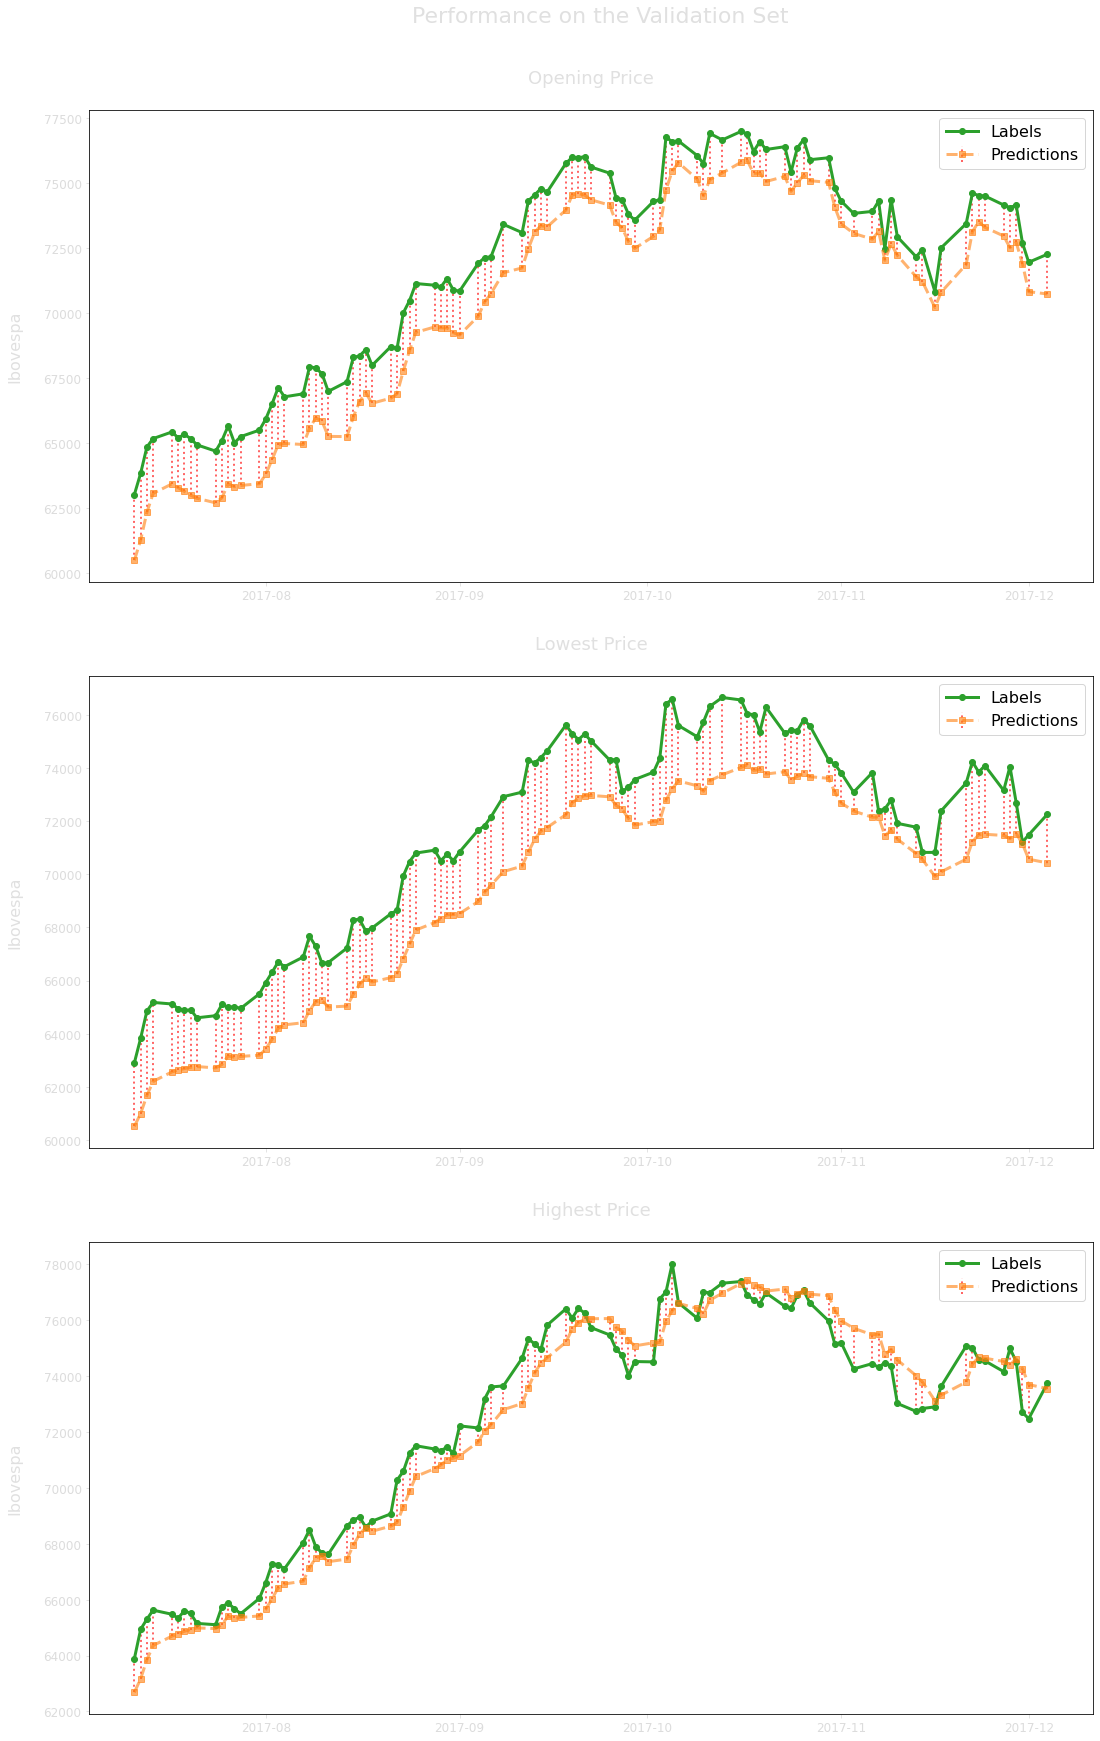

In [59]:
print("     Validation Data\n")
eval_print(results[symbol]["val"])
eval_plot(predictions[symbol]["val"], 
          multi_data[symbol].raw_val["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Validation Set")

#### **5.3) Test data**

    Test Data

#########################

[> GENERAL <]
   . MAE:   3257
   . MAPE:  3.2619%
   . MSE:   21852824

#########################

[> OPEN <]
   . MAE:   1155
   . MAPE:  1.1732%
   . MSE:   2231912
   . Tendency Accuracy:  70.4478%

#########################

[> LOW <]
   . MAE:   6956
   . MAPE:  6.9017%
   . MSE:   57985470
   . Tendency Accuracy:  42.0896%

#########################

[> HIGH <]
   . MAE:   1661
   . MAPE:  1.7107%
   . MSE:   5341088
   . Tendency Accuracy:  49.8507%

#########################


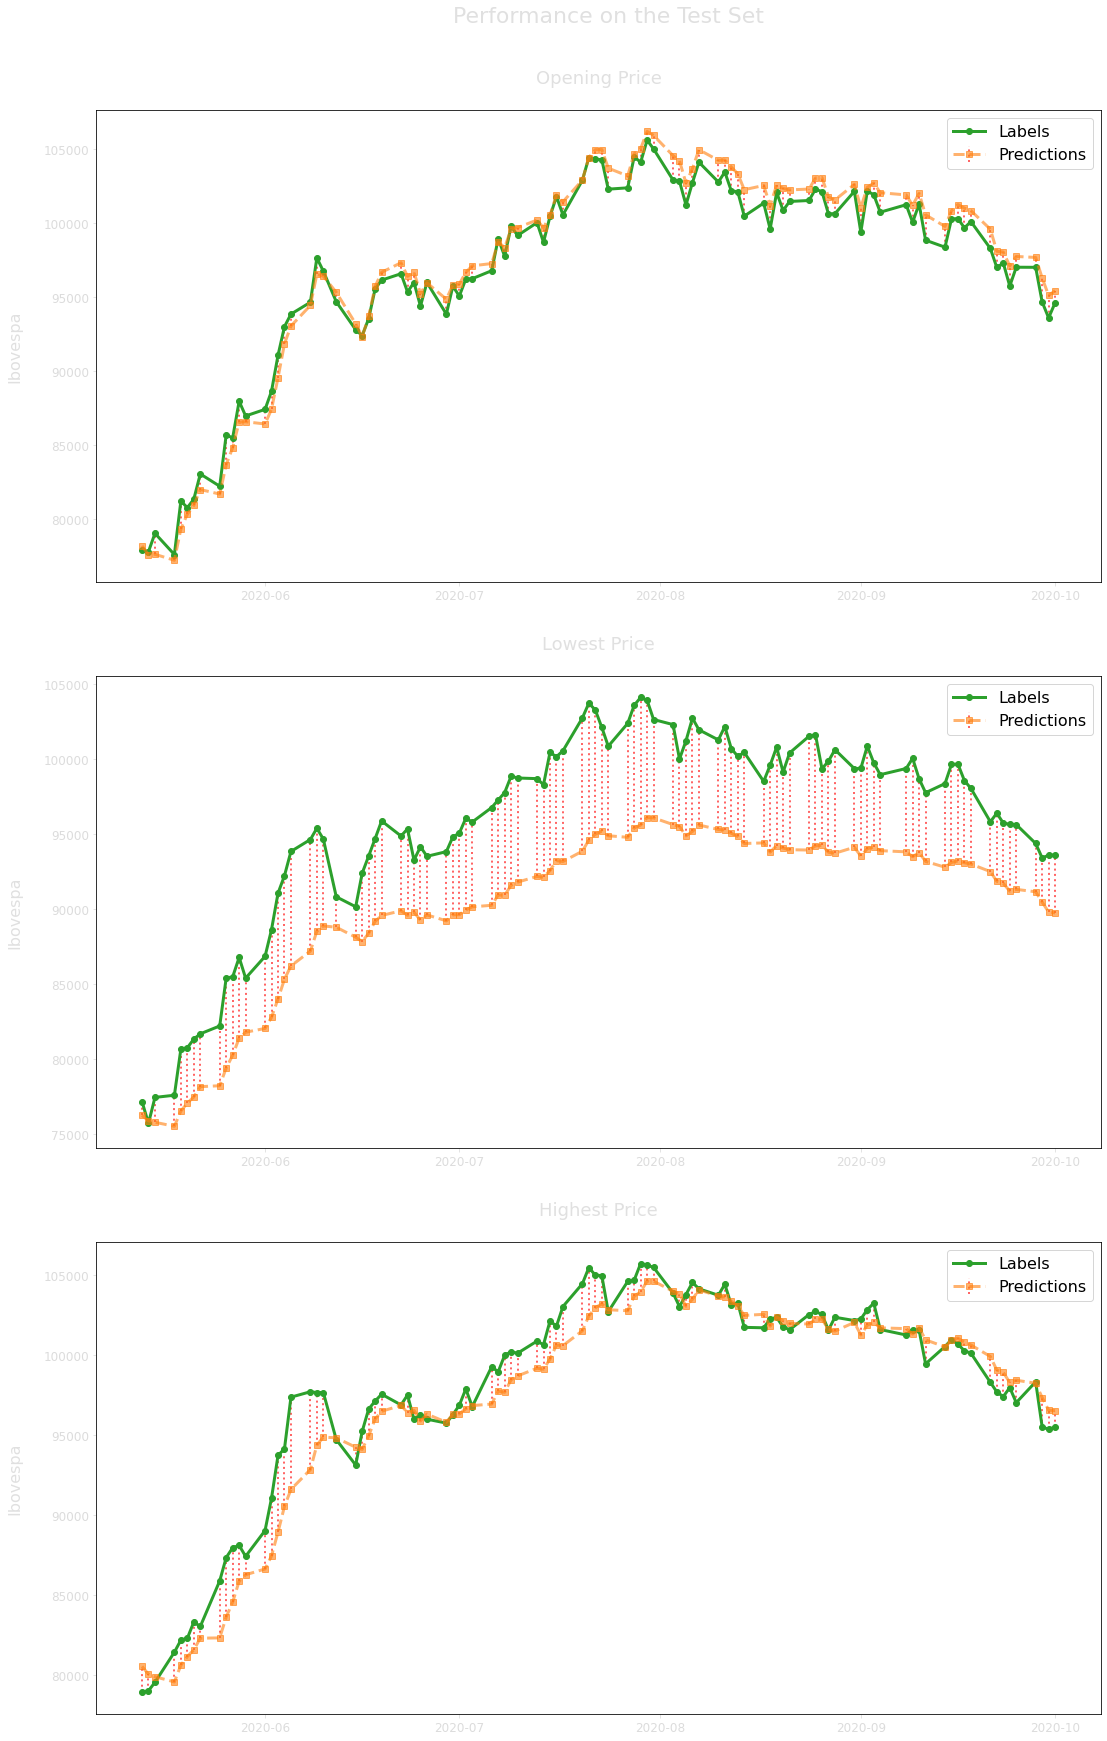

In [60]:
print("    Test Data\n")
eval_print(results[symbol]["test"])
eval_plot(predictions[symbol]["test"], 
          multi_data[symbol].raw_test["labels"], 
          start_date="random", 
          plot_samples=100, 
          title="Performance on the Test Set")